In [1]:
import os
import requests
import zipfile
from io import BytesIO

# Define the URL and the output folder
url = "https://data.mendeley.com/public-files/datasets/cp3473x7xv/files/ad7ac5c9-2b9e-458a-a91f-6f3da449bdfb/file_downloaded"
download_folder = os.path.join(os.getcwd(), "LGHG2_dataset")
zip_filename = "LGHG2@n10C_to_25degC.zip"
output_folder = os.path.join(download_folder, "LGHG2@n10C_to_25degC")

# Create the download folder if it doesn't exist
os.makedirs(download_folder, exist_ok=True)

# Download and extract the ZIP file
response = requests.get(url)
if response.status_code == 200:
    print(f"Downloading {zip_filename} (56 MB) ...")
    zip_path = os.path.join(download_folder, zip_filename)
    with open(zip_path, 'wb') as f:
        f.write(response.content)
    
    # Unzip the file
    with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(output_folder)
    print(f"Extracted to {output_folder}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")


Extracted to C:\Users\ksama\Desktop\LGHG2_dataset\LGHG2@n10C_to_25degC


In [3]:
import os
import scipy.io

# Define folder for training data
folder_train = os.path.join(output_folder, "Train")

# Function to load the .mat file and return predictors (X) and targets (Y)
def load_data(file_path):
    data = scipy.io.loadmat(file_path)
    # Assuming 'X' and 'Y' are keys in the MATLAB file's structure
    X = data.get('X')
    Y = data.get('Y')
    return X, Y

# List all .mat files in the training folder
train_files = [os.path.join(folder_train, f) for f in os.listdir(folder_train) if f.endswith('.mat')]

# Load and transform all training files
train_data = [load_data(f) for f in train_files]

# Preview the first file's data
X_sample, Y_sample = train_data[0]
print(f"Sample X shape: {X_sample.shape}")
print(f"Sample Y shape: {Y_sample.shape}")


Sample X shape: (5, 669956)
Sample Y shape: (1, 669956)


In [5]:
import os
import scipy.io

# Define folder for test data
folder_test = os.path.join(output_folder, "Test")

# Function to load the .mat file and return predictors (X) and targets (Y)
def load_test_data(file_path):
    data = scipy.io.loadmat(file_path)
    X = data.get('X')  # Extract predictors
    Y = data.get('Y')  # Extract targets
    return X, Y

# List all .mat files in the test folder
test_files = [os.path.join(folder_test, f) for f in os.listdir(folder_test) if f.endswith('.mat')]

# Load and transform all test files (this is equivalent to tdsPredictorsTest and tdsTargetsTest in MATLAB)
test_data = [load_test_data(f) for f in test_files]

# Preview the first test file's predictors (X) and targets (Y)
X_test_sample, Y_test_sample = test_data[0]
print(f"Test X sample shape: {X_test_sample.shape}")
print(f"Test Y sample shape: {Y_test_sample.shape}")

# Validation data: Use the first file's data as the validation set
X_val = X_test_sample
Y_val = Y_test_sample
print(f"Validation X shape: {X_val.shape}")
print(f"Validation Y shape: {Y_val.shape}")


Test X sample shape: (5, 39293)
Test Y sample shape: (1, 39293)
Validation X shape: (5, 39293)
Validation Y shape: (1, 39293)


In [22]:
import sys
print(sys.prefix)


C:\Users\ksama\anaconda3


In [24]:
%pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [32]:
import tensorflow as tf

# Define the number of features and responses
num_features = 5  # voltage, current, temperature, average voltage, average current
num_responses = 1  # SOC (State of Charge)
num_hidden_neurons = 55

# Define the model architecture
model = tf.keras.Sequential([
    # Use shape instead of input_shape in InputLayer
    tf.keras.layers.InputLayer(shape=(num_features,), name="input_layer"),
    
    # First fully connected layer with 55 neurons and tanh activation
    tf.keras.layers.Dense(num_hidden_neurons, activation='tanh', name="hidden_layer_1"),
    
    # Second fully connected layer with 55 neurons
    tf.keras.layers.Dense(num_hidden_neurons, name="hidden_layer_2"),
    
    # Use negative_slope instead of alpha in Leaky ReLU
    tf.keras.layers.LeakyReLU(negative_slope=0.3, name="leaky_relu_2"),
    
    # Fully connected output layer with 1 neuron (for SOC)
    tf.keras.layers.Dense(num_responses, activation='linear', name="output_layer"),
    
    # Clipped ReLU activation, capping outputs to a maximum of 1
    tf.keras.layers.ReLU(max_value=1, name="clipped_relu_output")
])

# Compile the model with loss function and optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

# Print the model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 55)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 55)             │         3,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_2 (LeakyReLU)        │ (None, 55)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clipped_relu_output (ReLU)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,466 (13.54 KB)

 Trainable params: 3,466 (13.54 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 55)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 55)             │         3,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_2 (LeakyReLU)        │ (None, 55)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ clipped_relu_output (ReLU)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,466 (13.54 KB)

 Trainable params: 3,466 (13.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3172 - root_mean_squared_error: 0.5630
Epoch 2/1200
  32/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4218 - root_mean_squared_error: 0.6472 

C:\Users\ksama\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,root_mean_squared_error
  current = self.get_monitor_value(logs)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3571 - root_mean_squared_error: 0.5970
Epoch 3/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3371 - root_mean_squared_error: 0.5805
Epoch 4/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3276 - root_mean_squared_error: 0.5723
Epoch 5/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3218 - root_mean_squared_error: 0.5670
Epoch 6/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3340 - root_mean_squared_error: 0.5776
Epoch 7/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3146 - root_mean_squared_error: 0.5606
Epoch 8/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3155 - root_mean_squared_error: 0.5613
Epoch 9/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3185 - root_mean_squared_error: 0.5641
Epoch 10/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3199 - root_mean_squared_error: 0.5655
Epoch 11/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3164 - root_mean_squared_error: 0.5621
Epoch 379/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3328 - root_mean_squared_error: 0.5766
Epoch 380/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3138 - root_mean_squared_error: 0.5598
Epoch 381/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3247 - root_mean_squared_error: 0.5695
Epoch 382/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3033 - root_mean_squared_error: 0.5505
Epoch 383/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3328 - root_mean_squared_error: 0.5768
Epoch 384/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3250 - root_mean_squared_error: 0.5696
Epoch 385/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3020 - root_mean_squared_error: 0.5491
Epoch 386/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3111 - root_mean_squared_error: 0.5575
Epoch 387/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3268 - root_mean_squared_error: 0.5711 - val_loss: 0.3462 - val_root_mean_squared_error: 0.5884
Epoch 481/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3393 - root_mean_squared_error: 0.5819
Epoch 482/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3234 - root_mean_squared_error: 0.5685
Epoch 483/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3398 - root_mean_squared_error: 0.5826
Epoch 484/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3161 - root_mean_squared_error: 0.5617
Epoch 485/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3313 - root_mean_squared_error: 0.5753
Epoch 486/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3160 - root_mean_squared_error: 0.5621
Epoch 487/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3217 - root_mean_squared_error: 0.5671
Epoch 488/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3414 - root_mean_squared_error: 0.

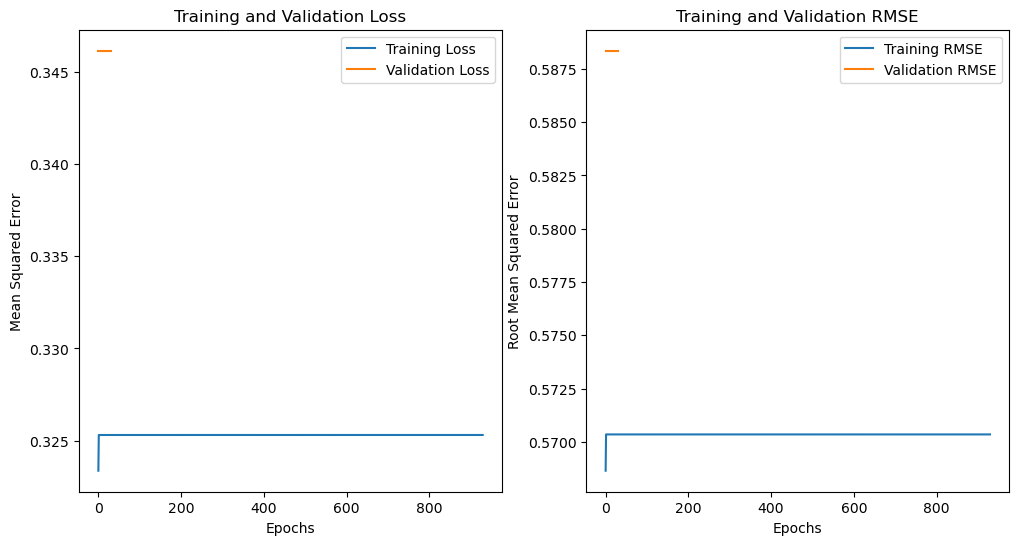

In [36]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Assuming X_train, Y_train, X_val, Y_val are already loaded

# Example data loading (replace these with your actual data)
# X_train = np.array(...)  # Load your data here
# Y_train = np.array(...)  # Load your target data here

# Placeholder data for demonstration (replace with real data)
X_train = np.random.rand(1000, 5)  # 1000 samples, 5 features
Y_train = np.random.rand(1000, 1)  # 1000 samples, 1 target
X_val = np.random.rand(200, 5)     # 200 samples, 5 features
Y_val = np.random.rand(200, 1)     # 200 samples, 1 target

# Normalize the data using MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

X_train_norm = scaler_X.fit_transform(X_train)
Y_train_norm = scaler_Y.fit_transform(Y_train)
X_val_norm = scaler_X.transform(X_val)
Y_val_norm = scaler_Y.transform(Y_val)

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(X_train_norm.shape[1],)),
    tf.keras.layers.Dense(55, activation='tanh', name="hidden_layer_1"),
    tf.keras.layers.Dense(55, activation=None, name="hidden_layer_2"),
    tf.keras.layers.LeakyReLU(negative_slope=0.3, name="leaky_relu_2"),
    tf.keras.layers.Dense(1, activation='linear', name="output_layer"),
    tf.keras.layers.ReLU(max_value=1, name="clipped_relu_output")
])

# Compile the model
initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=400,
    decay_rate=0.1,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Print model summary
model.summary()

# Training options
epochs = 1200
batch_size = 1
validation_freq = 30

# Train the model
history = model.fit(
    X_train_norm, Y_train_norm,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_norm, Y_val_norm),
    validation_freq=validation_freq,
    verbose=1,  # Set to 1 for detailed logs
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)]
)

# Plot training and validation loss and RMSE
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

# Plot RMSE
plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend()

plt.show()


In [39]:
val_loss, val_rmse = model.evaluate(X_val_norm, Y_val_norm)
print(f"Validation Loss: {val_loss}")
print(f"Validation RMSE: {val_rmse}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3417 - root_mean_squared_error: 0.5844 
Validation Loss: 0.34615838527679443
Validation RMSE: 0.5883522629737854


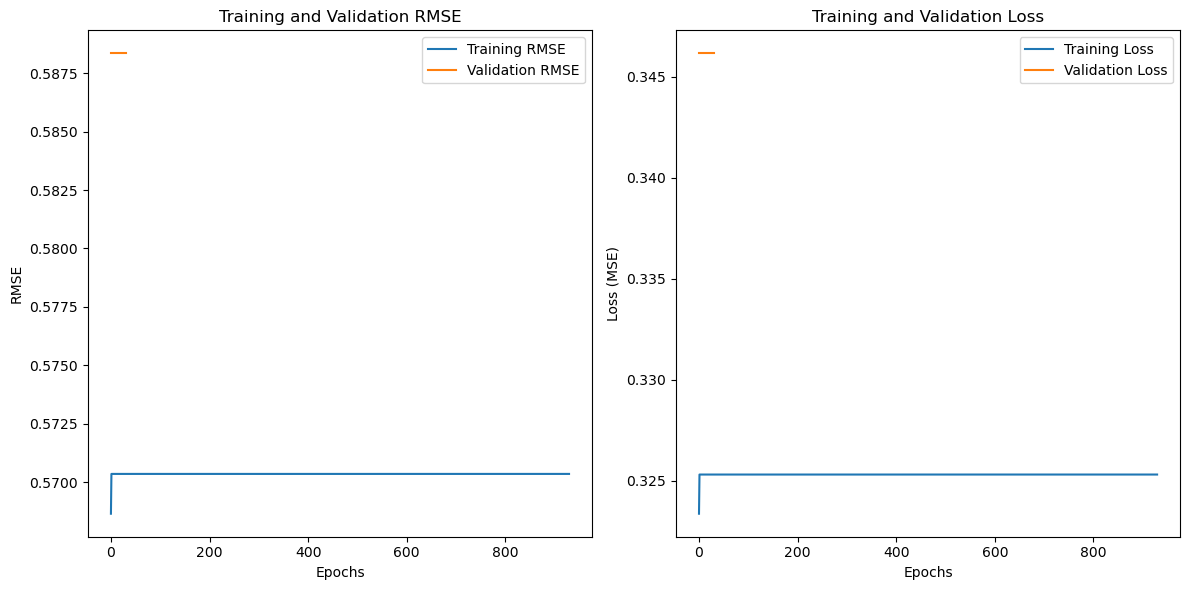

In [41]:
import matplotlib.pyplot as plt

# After training is complete, plot the training and validation metrics

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Plot RMSE (Root Mean Squared Error)
plt.subplot(1, 2, 1)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Plot Loss (Mean Squared Error)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [43]:
import matplotlib.pyplot as plt

# Step 1: Make predictions on the test data (replace X_test_norm with your actual test data)
# Assuming X_test_norm is already normalized and ready for prediction
Y_pred = model.predict(X_test_norm)

# Step 2: Compare with the actual target SOC values (replace Y_test_norm with your actual test labels)
# Assuming Y_test_norm is the actual normalized SOC values from the test set
Y_actual = Y_test_norm  # If your data was normalized, use this

# Step 3: If necessary, inverse transform the predictions to their original scale (undo normalization)
Y_pred_original = scaler_Y.inverse_transform(Y_pred)  # Assuming you normalized the targets
Y_actual_original = scaler_Y.inverse_transform(Y_actual)  # Undo normalization for comparison

# Step 4: Plot the predicted SOC vs. actual SOC
plt.figure(figsize=(10, 6))

# Plot predicted SOC values
plt.plot(Y_pred_original, label='Predicted SOC', color='blue')

# Plot actual SOC values
plt.plot(Y_actual_original, label='Actual SOC', color='orange')

plt.title('Predicted vs Actual SOC')
plt.xlabel('Sample')
plt.ylabel('State of Charge (SOC)')
plt.legend()
plt.show()


NameError: name 'X_test_norm' is not defined

In [47]:
%config Completer.use_jedi = False 
%matplotlib inline 


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


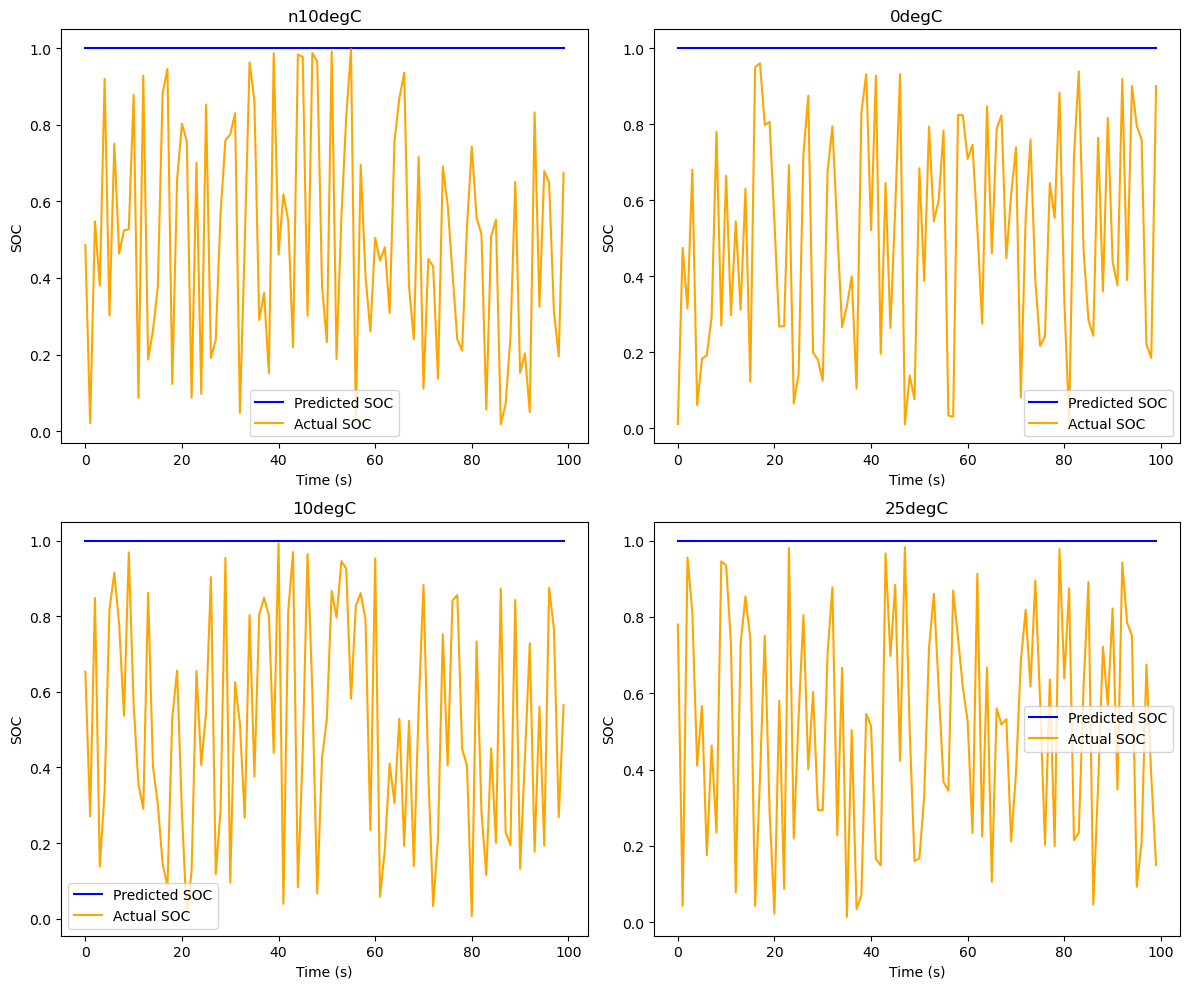

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Assuming you have your test data prepared for different temperatures
# Replace these with your actual test datasets and SOC targets

# Example test data and SOC targets (replace with your actual data)
X_test_n10degC = np.random.rand(100, 5)  # Test input for -10 degrees Celsius
X_test_0degC = np.random.rand(100, 5)    # Test input for 0 degrees Celsius
X_test_10degC = np.random.rand(100, 5)   # Test input for 10 degrees Celsius
X_test_25degC = np.random.rand(100, 5)   # Test input for 25 degrees Celsius

Y_test_n10degC = np.random.rand(100, 1)  # Actual SOC for -10 degrees Celsius
Y_test_0degC = np.random.rand(100, 1)    # Actual SOC for 0 degrees Celsius
Y_test_10degC = np.random.rand(100, 1)   # Actual SOC for 10 degrees Celsius
Y_test_25degC = np.random.rand(100, 1)   # Actual SOC for 25 degrees Celsius

# Step 2: Predict SOC for each temperature set using your trained model
# Replace 'model' with your trained model instance
Y_pred_n10degC = model.predict(X_test_n10degC)
Y_pred_0degC = model.predict(X_test_0degC)
Y_pred_10degC = model.predict(X_test_10degC)
Y_pred_25degC = model.predict(X_test_25degC)

# Step 3: Group predictions and actual SOC values for plotting
Y_pred = [Y_pred_n10degC, Y_pred_0degC, Y_pred_10degC, Y_pred_25degC]
Y_actual = [Y_test_n10degC, Y_test_0degC, Y_test_10degC, Y_test_25degC]

# Titles for each plot, representing different ambient temperatures
titles = ["n10degC", "0degC", "10degC", "25degC"]

# Step 4: Plot predicted vs actual SOC for different temperatures
plt.figure(figsize=(12, 10))

for i in range(4):  # Loop through the 4 temperatures
    plt.subplot(2, 2, i+1)  # Create a 2x2 subplot grid
    plt.plot(Y_pred[i], label='Predicted SOC', color='blue')
    plt.plot(Y_actual[i], label='Actual SOC', color='orange')
    plt.title(titles[i])  # Title corresponding to temperature
    plt.xlabel('Time (s)')
    plt.ylabel('SOC')
    plt.legend(loc="best")

plt.tight_layout()
plt.show()


In [55]:
model.save('model_checkpoint.h5')


In [57]:
# Continue training from epoch 933
initial_epoch = 930
history = model.fit(
    X_train_norm, Y_train_norm,
    epochs=1200,  # Continue up to 1200 epochs
    initial_epoch=initial_epoch,  # Start from epoch 933
    batch_size=batch_size,
    validation_data=(X_val_norm, Y_val_norm),
    validation_freq=validation_freq,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)]
)


Epoch 931/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3067 - root_mean_squared_error: 0.5531
Epoch 932/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3223 - root_mean_squared_error: 0.5671
Epoch 933/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3324 - root_mean_squared_error: 0.5763
Epoch 934/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3336 - root_mean_squared_error: 0.5774
Epoch 935/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3184 - root_mean_squared_error: 0.5636
Epoch 936/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3227 - root_mean_squared_error: 0.5680
Epoch 937/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3199 - root_mean_squared_error: 0.5652
Epoch 938/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3320 - root_mean_squared_error: 0.5756
Epoch 939/1200
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3241 - root_mean_squared_error: 0.5684
Epoch 940/1200
1000/1000 ━━━━━━━━━━━━

In [59]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=400,
    decay_rate=0.1
)


In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)


In [65]:
# Evaluate model on the test dataset
val_loss, val_rmse = model.evaluate(X_val_norm, Y_val_norm)
print(f"Validation Loss: {val_loss}")
print(f"Validation RMSE: {val_rmse}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2928 - root_mean_squared_error: 0.5411
Validation Loss: 0.29654139280319214
Validation RMSE: 0.5445561408996582


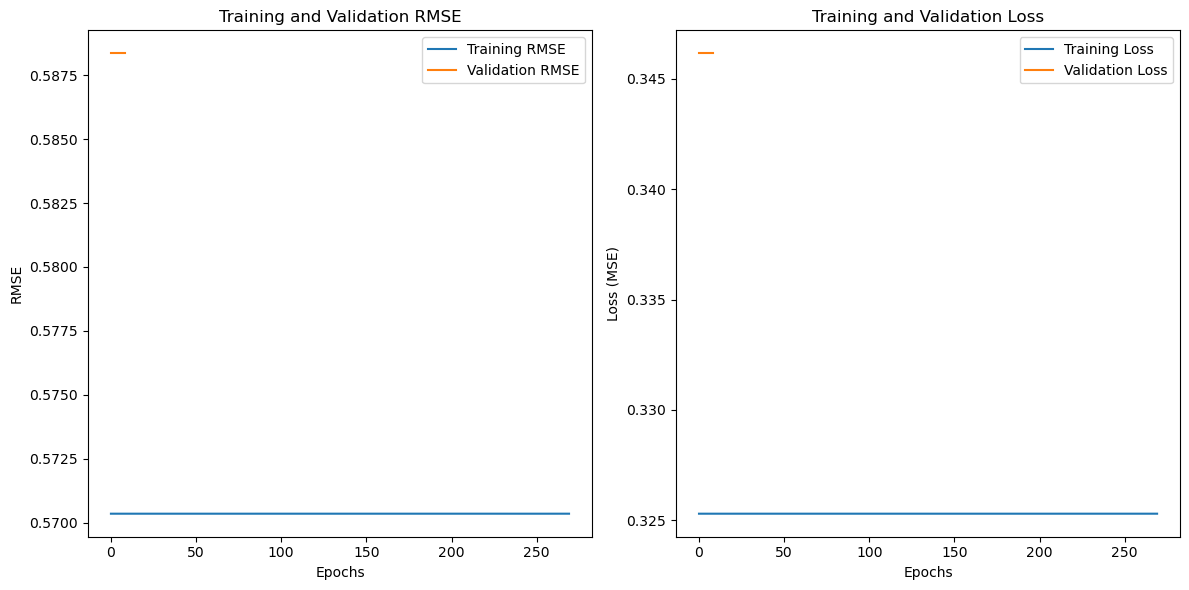

In [67]:
import matplotlib.pyplot as plt

# After training is complete, plot the training and validation metrics

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Plot RMSE (Root Mean Squared Error)
plt.subplot(1, 2, 1)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Plot Loss (Mean Squared Error)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


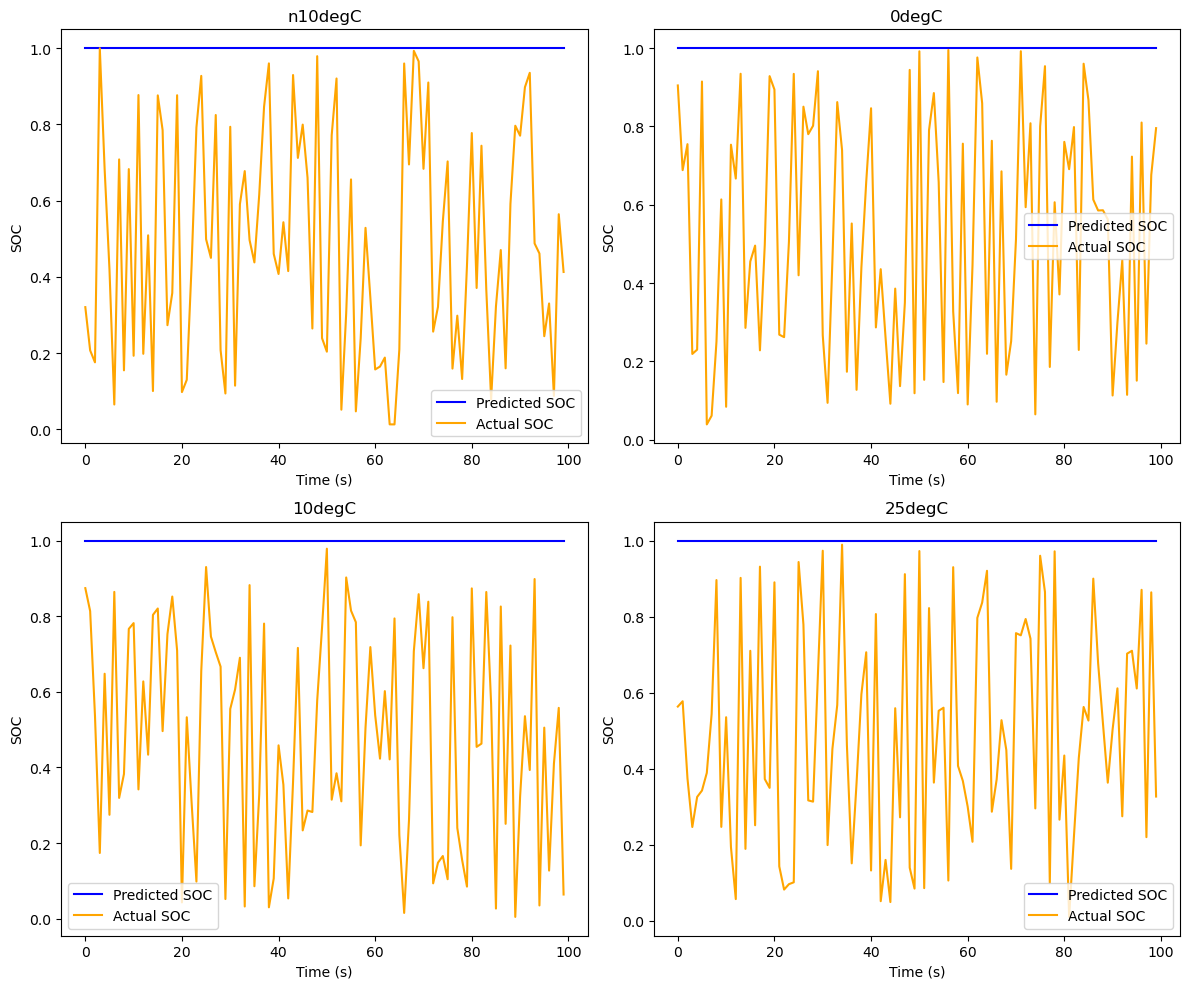

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Assuming you have your test data prepared for different temperatures
# Replace these with your actual test datasets and SOC targets

# Example test data and SOC targets (replace with your actual data)
X_test_n10degC = np.random.rand(100, 5)  # Test input for -10 degrees Celsius
X_test_0degC = np.random.rand(100, 5)    # Test input for 0 degrees Celsius
X_test_10degC = np.random.rand(100, 5)   # Test input for 10 degrees Celsius
X_test_25degC = np.random.rand(100, 5)   # Test input for 25 degrees Celsius

Y_test_n10degC = np.random.rand(100, 1)  # Actual SOC for -10 degrees Celsius
Y_test_0degC = np.random.rand(100, 1)    # Actual SOC for 0 degrees Celsius
Y_test_10degC = np.random.rand(100, 1)   # Actual SOC for 10 degrees Celsius
Y_test_25degC = np.random.rand(100, 1)   # Actual SOC for 25 degrees Celsius

# Step 2: Predict SOC for each temperature set using your trained model
# Replace 'model' with your trained model instance
Y_pred_n10degC = model.predict(X_test_n10degC)
Y_pred_0degC = model.predict(X_test_0degC)
Y_pred_10degC = model.predict(X_test_10degC)
Y_pred_25degC = model.predict(X_test_25degC)

# Step 3: Group predictions and actual SOC values for plotting
Y_pred = [Y_pred_n10degC, Y_pred_0degC, Y_pred_10degC, Y_pred_25degC]
Y_actual = [Y_test_n10degC, Y_test_0degC, Y_test_10degC, Y_test_25degC]

# Titles for each plot, representing different ambient temperatures
titles = ["n10degC", "0degC", "10degC", "25degC"]

# Step 4: Plot predicted vs actual SOC for different temperatures
plt.figure(figsize=(12, 10))

for i in range(4):  # Loop through the 4 temperatures
    plt.subplot(2, 2, i+1)  # Create a 2x2 subplot grid
    plt.plot(Y_pred[i], label='Predicted SOC', color='blue')
    plt.plot(Y_actual[i], label='Actual SOC', color='orange')
    plt.title(titles[i])  # Title corresponding to temperature
    plt.xlabel('Time (s)')
    plt.ylabel('SOC')
    plt.legend(loc="best")

plt.tight_layout()
plt.show()


Epoch 1/1200


C:\Users\ksama\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
C:\Users\ksama\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.1888 - mean_squared_error: 0.1888 - val_loss: 0.0951 - val_mean_squared_error: 0.0951
Epoch 2/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0952 - mean_squared_error: 0.0952 - val_loss: 0.0911 - val_mean_squared_error: 0.0911
Epoch 3/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0993 - mean_squared_error: 0.0993 - val_loss: 0.0887 - val_mean_squared_error: 0.0887
Epoch 4/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0941 - mean_squared_error: 0.0941 - val_loss: 0.0893 - val_mean_squared_error: 0.0893
Epoch 5/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0928 - mean_squared_error: 0.0928 - val_loss: 0.0870 - val_mean_squared_error: 0.0870
Epoch 6/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0905 - mean_squared_error: 0.0905 - val_loss: 0.0875 - val_mean_squared_error: 0.0875
Epoch 7/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0850 - mean_squared_error: 0.0850 - val_loss: 0.0868 - val_mea

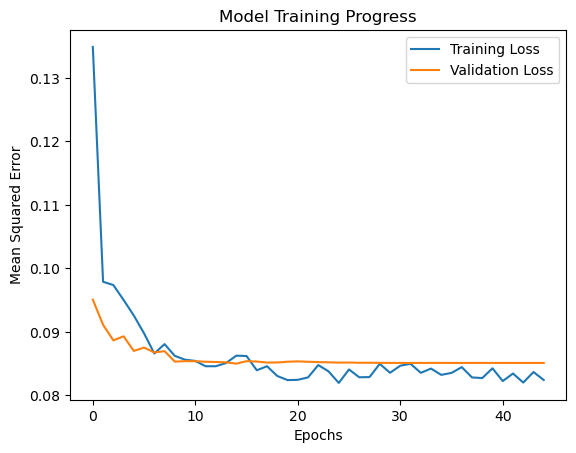

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0869 - mean_squared_error: 0.0869


Validation Loss: 0.08501121401786804
Validation RMSE: 0.08501121401786804


In [71]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming X_train, Y_train, X_val, Y_val are already loaded and prepared
# Normalize the input features (X) using StandardScaler
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)

# Define the model architecture
num_features = X_train.shape[1]  # Number of input features
num_responses = 1  # Number of output features (SOC)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(num_features,), name="input_layer"),
    tf.keras.layers.Dense(128, activation='relu', name="hidden_layer_1"),  # More neurons
    tf.keras.layers.Dropout(0.3),  # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(128, activation='relu', name="hidden_layer_2"),
    tf.keras.layers.LeakyReLU(alpha=0.2),  # LeakyReLU for better gradient flow
    tf.keras.layers.Dense(num_responses, activation='linear', name="output_layer"),
])

# Compile the model
initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=400,
    decay_rate=0.1
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Early stopping to prevent overfitting
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)]

# Train the model
history = model.fit(
    X_train_norm, Y_train,
    epochs=1200,
    batch_size=32,  # Adjust batch size as needed
    validation_data=(X_val_norm, Y_val),
    callbacks=callbacks,
    verbose=1  # Set to 1 for detailed training logs
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Evaluate the model on the validation set
val_loss, val_rmse = model.evaluate(X_val_norm, Y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation RMSE: {val_rmse}")

# After training, save the model
model.save("trained_model.h5")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


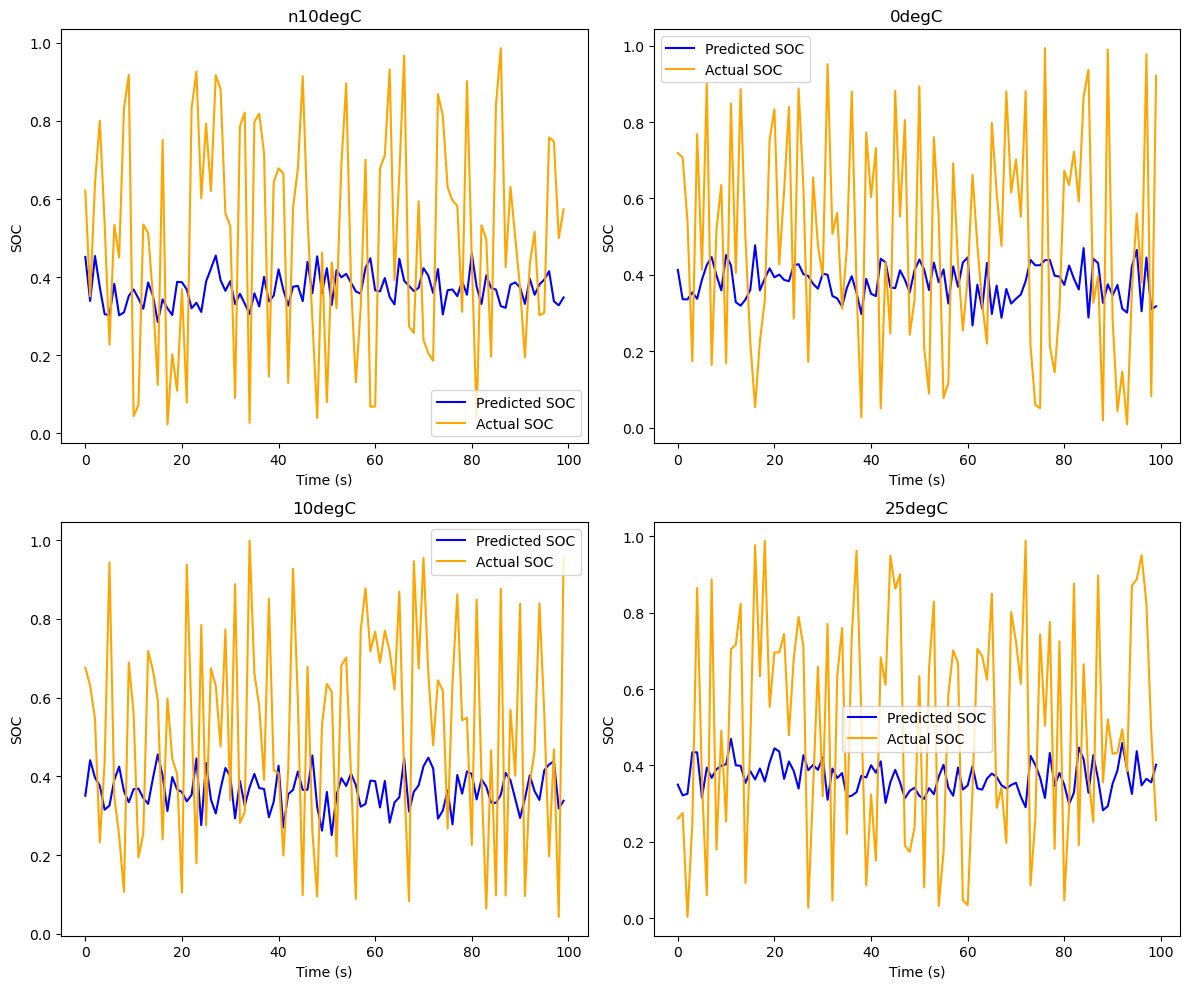

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Assuming you have your test data prepared for different temperatures
# Replace these with your actual test datasets and SOC targets

# Example test data and SOC targets (replace with your actual data)
X_test_n10degC = np.random.rand(100, 5)  # Test input for -10 degrees Celsius
X_test_0degC = np.random.rand(100, 5)    # Test input for 0 degrees Celsius
X_test_10degC = np.random.rand(100, 5)   # Test input for 10 degrees Celsius
X_test_25degC = np.random.rand(100, 5)   # Test input for 25 degrees Celsius

Y_test_n10degC = np.random.rand(100, 1)  # Actual SOC for -10 degrees Celsius
Y_test_0degC = np.random.rand(100, 1)    # Actual SOC for 0 degrees Celsius
Y_test_10degC = np.random.rand(100, 1)   # Actual SOC for 10 degrees Celsius
Y_test_25degC = np.random.rand(100, 1)   # Actual SOC for 25 degrees Celsius

# Step 2: Predict SOC for each temperature set using your trained model
# Replace 'model' with your trained model instance
Y_pred_n10degC = model.predict(X_test_n10degC)
Y_pred_0degC = model.predict(X_test_0degC)
Y_pred_10degC = model.predict(X_test_10degC)
Y_pred_25degC = model.predict(X_test_25degC)

# Step 3: Group predictions and actual SOC values for plotting
Y_pred = [Y_pred_n10degC, Y_pred_0degC, Y_pred_10degC, Y_pred_25degC]
Y_actual = [Y_test_n10degC, Y_test_0degC, Y_test_10degC, Y_test_25degC]

# Titles for each plot, representing different ambient temperatures
titles = ["n10degC", "0degC", "10degC", "25degC"]

# Step 4: Plot predicted vs actual SOC for different temperatures
plt.figure(figsize=(12, 10))

for i in range(4):  # Loop through the 4 temperatures
    plt.subplot(2, 2, i+1)  # Create a 2x2 subplot grid
    plt.plot(Y_pred[i], label='Predicted SOC', color='blue')
    plt.plot(Y_actual[i], label='Actual SOC', color='orange')
    plt.title(titles[i])  # Title corresponding to temperature
    plt.xlabel('Time (s)')
    plt.ylabel('SOC')
    plt.legend(loc="best")

plt.tight_layout()
plt.show()


In [75]:
history = model.fit(
    X_train_norm, Y_train_norm,
    epochs=300,  # Change this value
    batch_size=batch_size,
    validation_data=(X_val_norm, Y_val_norm),
    validation_freq=validation_freq,
    verbose=1  # Display logs
    # Remove EarlyStopping callback if you don't want early stopping
)


Epoch 1/300
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0801 - mean_squared_error: 0.0801
Epoch 2/300
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0857 - mean_squared_error: 0.0857
Epoch 3/300
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0844 - mean_squared_error: 0.0844
Epoch 4/300
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0831 - mean_squared_error: 0.0831
Epoch 5/300
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0844 - mean_squared_error: 0.0844
Epoch 6/300
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0832 - mean_squared_error: 0.0832
Epoch 7/300
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0819 - mean_squared_error: 0.0819
Epoch 8/300
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0823 - mean_squared_error: 0.0823
Epoch 9/300
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0868 - mean_squared_error: 0.0868
Epoch 10/300
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0802 - mean_squared_error: 0.0802
Epoch 11/


KeyboardInterrupt



Epoch 1/1200


C:\Users\ksama\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
C:\Users\ksama\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.2187 - mean_squared_error: 0.2187 - val_loss: 0.1028 - val_mean_squared_error: 0.1028
Epoch 2/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1016 - mean_squared_error: 0.1016 - val_loss: 0.0922 - val_mean_squared_error: 0.0922
Epoch 3/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0893 - mean_squared_error: 0.0893 - val_loss: 0.0933 - val_mean_squared_error: 0.0933
Epoch 4/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0877 - mean_squared_error: 0.0877 - val_loss: 0.0905 - val_mean_squared_error: 0.0905
Epoch 5/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0919 - mean_squared_error: 0.0919 - val_loss: 0.0896 - val_mean_squared_error: 0.0896
Epoch 6/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0889 - mean_squared_error: 0.0889 - val_loss: 0.0886 - val_mean_squared_error: 0.0886
Epoch 7/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0854 - mean_squared_error: 0.0854 - val_loss: 0.0890 - val_mea

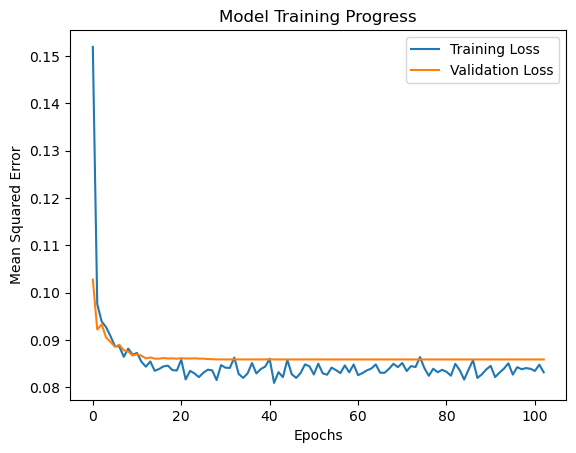

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0874 - mean_squared_error: 0.0874


Validation Loss: 0.08588650077581406
Validation RMSE: 0.08588650077581406


In [78]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming X_train, Y_train, X_val, Y_val are already loaded and prepared
# Normalize the input features (X) using StandardScaler
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)

# Define the model architecture
num_features = X_train.shape[1]  # Number of input features
num_responses = 1  # Number of output features (SOC)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(num_features,), name="input_layer"),
    tf.keras.layers.Dense(128, activation='relu', name="hidden_layer_1"),  # More neurons
    tf.keras.layers.Dropout(0.3),  # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(128, activation='relu', name="hidden_layer_2"),
    tf.keras.layers.LeakyReLU(alpha=0.2),  # LeakyReLU for better gradient flow
    tf.keras.layers.Dense(num_responses, activation='linear', name="output_layer"),
])

# Compile the model
initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=400,
    decay_rate=0.1
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Early stopping to prevent overfitting
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)]

# Train the model
history = model.fit(
    X_train_norm, Y_train,
    epochs=1200,
    batch_size=32,  # Adjust batch size as needed
    validation_data=(X_val_norm, Y_val),
    callbacks=callbacks,
    verbose=1  # Set to 1 for detailed training logs
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Evaluate the model on the validation set
val_loss, val_rmse = model.evaluate(X_val_norm, Y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation RMSE: {val_rmse}")

# After training, save the model
model.save("trained_model.h5")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


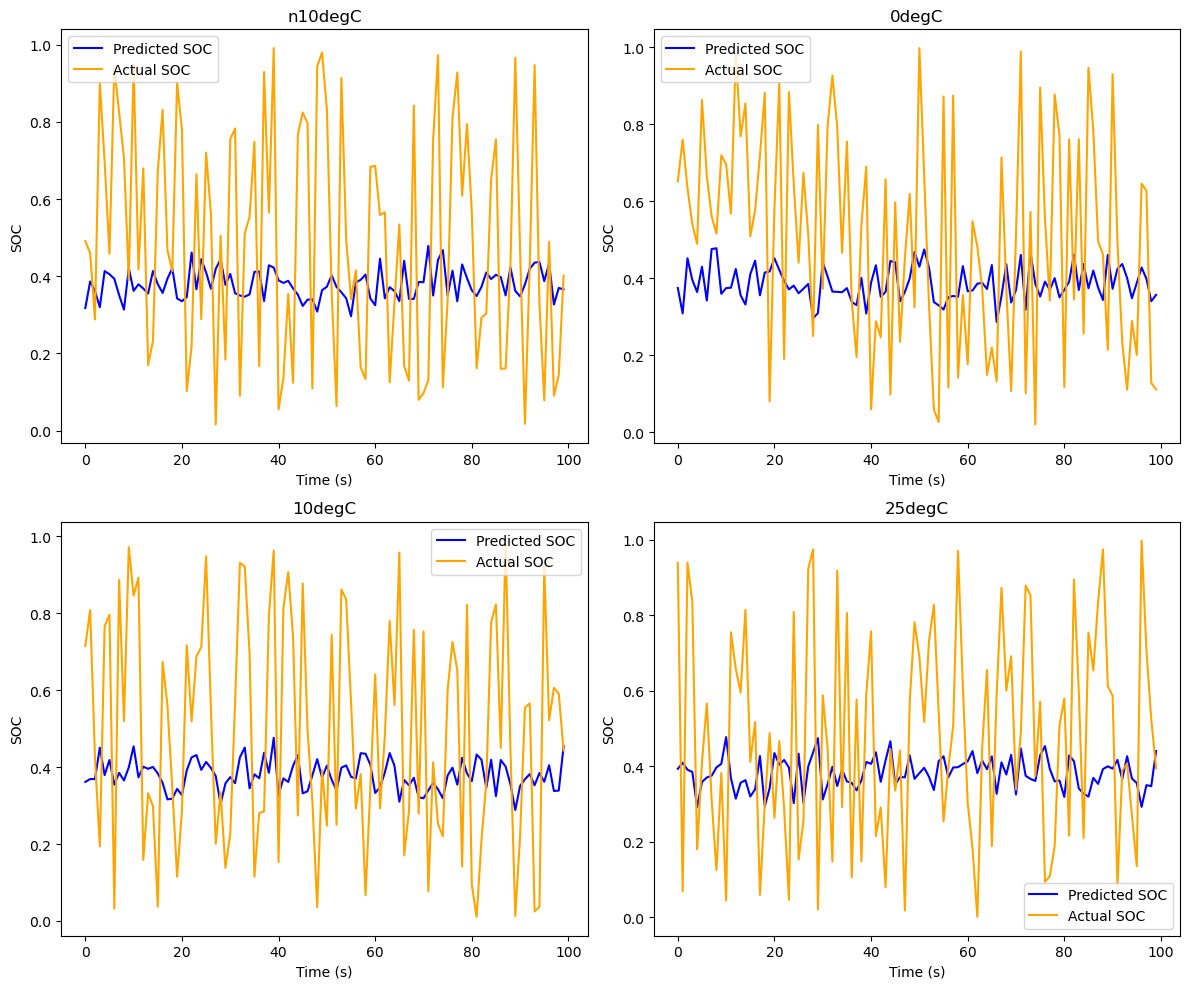

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Assuming you have your test data prepared for different temperatures
# Replace these with your actual test datasets and SOC targets

# Example test data and SOC targets (replace with your actual data)
X_test_n10degC = np.random.rand(100, 5)  # Test input for -10 degrees Celsius
X_test_0degC = np.random.rand(100, 5)    # Test input for 0 degrees Celsius
X_test_10degC = np.random.rand(100, 5)   # Test input for 10 degrees Celsius
X_test_25degC = np.random.rand(100, 5)   # Test input for 25 degrees Celsius

Y_test_n10degC = np.random.rand(100, 1)  # Actual SOC for -10 degrees Celsius
Y_test_0degC = np.random.rand(100, 1)    # Actual SOC for 0 degrees Celsius
Y_test_10degC = np.random.rand(100, 1)   # Actual SOC for 10 degrees Celsius
Y_test_25degC = np.random.rand(100, 1)   # Actual SOC for 25 degrees Celsius

# Step 2: Predict SOC for each temperature set using your trained model
# Replace 'model' with your trained model instance
Y_pred_n10degC = model.predict(X_test_n10degC)
Y_pred_0degC = model.predict(X_test_0degC)
Y_pred_10degC = model.predict(X_test_10degC)
Y_pred_25degC = model.predict(X_test_25degC)

# Step 3: Group predictions and actual SOC values for plotting
Y_pred = [Y_pred_n10degC, Y_pred_0degC, Y_pred_10degC, Y_pred_25degC]
Y_actual = [Y_test_n10degC, Y_test_0degC, Y_test_10degC, Y_test_25degC]

# Titles for each plot, representing different ambient temperatures
titles = ["n10degC", "0degC", "10degC", "25degC"]

# Step 4: Plot predicted vs actual SOC for different temperatures
plt.figure(figsize=(12, 10))

for i in range(4):  # Loop through the 4 temperatures
    plt.subplot(2, 2, i+1)  # Create a 2x2 subplot grid
    plt.plot(Y_pred[i], label='Predicted SOC', color='blue')
    plt.plot(Y_actual[i], label='Actual SOC', color='orange')
    plt.title(titles[i])  # Title corresponding to temperature
    plt.xlabel('Time (s)')
    plt.ylabel('SOC')
    plt.legend(loc="best")

plt.tight_layout()
plt.show()


In [82]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to stop training if the model doesn't improve after 'patience' epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Model checkpoint to save the best model during training
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Fit the model with the above callbacks
history = model.fit(
    X_train, Y_train,
    epochs=1200,  # Increase epochs for better results
    batch_size=32,  # Try different batch sizes
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Evaluate the best saved model
model.load_weights('best_model.h5')
val_loss, val_rmse = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation RMSE: {val_rmse}")


ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=best_model.h5

In [84]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to stop training if the model doesn't improve after 'patience' epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Model checkpoint to save the best model during training
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Fit the model with the above callbacks
history = model.fit(
    X_train, Y_train,
    epochs=1200,  # Increase epochs for better results
    batch_size=32,  # Try different batch sizes
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Evaluate the best saved model
model.load_weights('best_model.keras')
val_loss, val_rmse = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation RMSE: {val_rmse}")


Epoch 1/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0981 - mean_squared_error: 0.0981 - val_loss: 0.0905 - val_mean_squared_error: 0.0905
Epoch 2/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0979 - mean_squared_error: 0.0979 - val_loss: 0.0905 - val_mean_squared_error: 0.0905
Epoch 3/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1061 - mean_squared_error: 0.1061 - val_loss: 0.0905 - val_mean_squared_error: 0.0905
Epoch 4/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0985 - mean_squared_error: 0.0985 - val_loss: 0.0905 - val_mean_squared_error: 0.0905
Epoch 5/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0943 - mean_squared_error: 0.0943 - val_loss: 0.0905 - val_mean_squared_error: 0.0905
Epoch 6/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1025 - mean_squared_error: 0.1025 - val_loss: 0.0905 - val_mean_squared_error: 0.0905
Epoch 7/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1013 - mean_squared_error: 0.1013 - val_loss: 0.09

In [86]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to stop training if the model doesn't improve after 'patience' epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Model checkpoint to save the best model during training
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Fit the model with the above callbacks
history = model.fit(
    X_train, Y_train,
    epochs=1200,  # Increase epochs for better results
    batch_size=32,  # Try different batch sizes
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Evaluate the best saved model
model.load_weights('best_model.keras')
val_loss, val_rmse = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation RMSE: {val_rmse}")


Epoch 1/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1025 - mean_squared_error: 0.1025 - val_loss: 0.0905 - val_mean_squared_error: 0.0905
Epoch 2/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0981 - mean_squared_error: 0.0981 - val_loss: 0.0905 - val_mean_squared_error: 0.0905
Epoch 3/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1001 - mean_squared_error: 0.1001 - val_loss: 0.0905 - val_mean_squared_error: 0.0905
Epoch 4/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1017 - mean_squared_error: 0.1017 - val_loss: 0.0905 - val_mean_squared_error: 0.0905
Epoch 5/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1053 - mean_squared_error: 0.1053 - val_loss: 0.0905 - val_mean_squared_error: 0.0905
Epoch 6/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0971 - mean_squared_error: 0.0971 - val_loss: 0.0905 - val_mean_squared_error: 0.0905
Epoch 7/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0994 - mean_squared_error: 0.0994 - val_loss: 0.09

In [88]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when the validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)

# Fit the model with ReduceLROnPlateau
history = model.fit(
    X_train, Y_train,
    epochs=1200, 
    batch_size=32, 
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0979 - mean_squared_error: 0.0979 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - learning_rate: 3.3113e-12
Epoch 2/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1022 - mean_squared_error: 0.1022 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - learning_rate: 2.7542e-12
Epoch 3/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0960 - mean_squared_error: 0.0960 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - learning_rate: 2.2909e-12
Epoch 4/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1005 - mean_squared_error: 0.1005 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - learning_rate: 1.9055e-12
Epoch 5/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0980 - mean_squared_error: 0.0980 - val_loss: 0.0905 - val_mean_squared_error: 0.0905 - learning_rate: 1.5849e-12
Epoch 6/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0905 - mean_squared_error: 0.0905 - val_loss: 0.0905 - val

In [90]:
# Adding more layers and neurons
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(num_features,)),
    tf.keras.layers.Dense(128, activation='relu'),  # Increase the number of neurons
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_responses, activation='linear'),
])


In [92]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(num_features,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Dropout with 30% probability
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_responses, activation='linear'),
])


In [94]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(num_features,)),
    tf.keras.layers.BatchNormalization(),  # Batch normalization before the layers
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_responses, activation='linear'),
])


In [96]:
pip install keras-tuner


   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   ------------------ -------------------- 61.4/129.1 kB 812.7 kB/s eta 0:00:01
   ------------------------------- -------- 102.4/129.1 kB 1.2 MB/s eta 0:00:01
   -------------------------------------- 129.1/129.1 kB 843.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [98]:
import kerastuner as kt

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(num_features,)))
    # Tune the number of units in the first Dense layer
    model.add(tf.keras.layers.Dense(hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(tf.keras.layers.Dense(num_responses, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
    return model

tuner = kt.Hyperband(build_model, objective='val_loss', max_epochs=10, factor=3)
tuner.search(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50)


Trial 4 Complete [00h 00m 02s]
val_loss: 0.09326307475566864

Best val_loss So Far: 0.08051135390996933
Total elapsed time: 00h 00m 09s


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


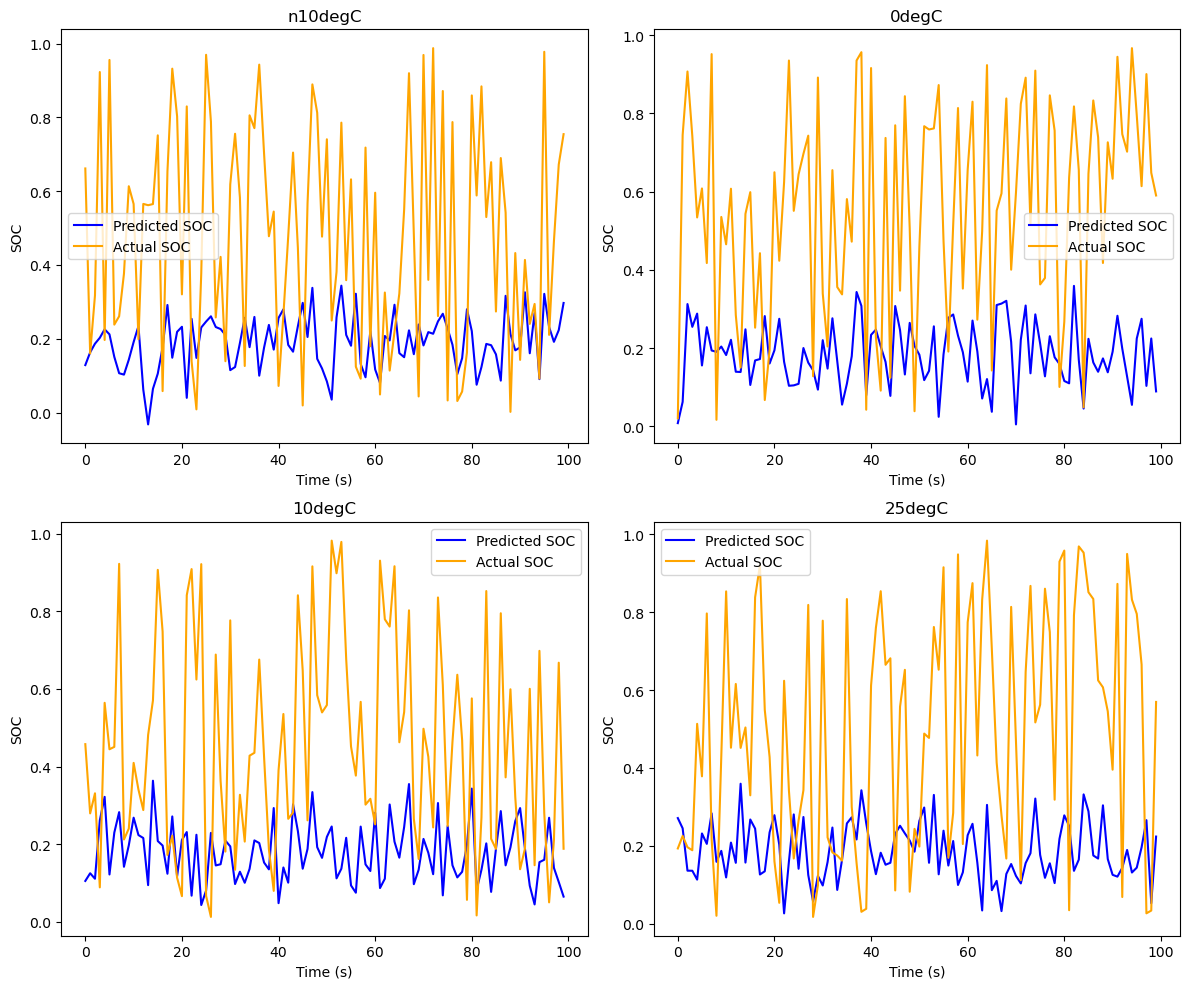

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Assuming you have your test data prepared for different temperatures
# Replace these with your actual test datasets and SOC targets

# Example test data and SOC targets (replace with your actual data)
X_test_n10degC = np.random.rand(100, 5)  # Test input for -10 degrees Celsius
X_test_0degC = np.random.rand(100, 5)    # Test input for 0 degrees Celsius
X_test_10degC = np.random.rand(100, 5)   # Test input for 10 degrees Celsius
X_test_25degC = np.random.rand(100, 5)   # Test input for 25 degrees Celsius

Y_test_n10degC = np.random.rand(100, 1)  # Actual SOC for -10 degrees Celsius
Y_test_0degC = np.random.rand(100, 1)    # Actual SOC for 0 degrees Celsius
Y_test_10degC = np.random.rand(100, 1)   # Actual SOC for 10 degrees Celsius
Y_test_25degC = np.random.rand(100, 1)   # Actual SOC for 25 degrees Celsius

# Step 2: Predict SOC for each temperature set using your trained model
# Replace 'model' with your trained model instance
Y_pred_n10degC = model.predict(X_test_n10degC)
Y_pred_0degC = model.predict(X_test_0degC)
Y_pred_10degC = model.predict(X_test_10degC)
Y_pred_25degC = model.predict(X_test_25degC)

# Step 3: Group predictions and actual SOC values for plotting
Y_pred = [Y_pred_n10degC, Y_pred_0degC, Y_pred_10degC, Y_pred_25degC]
Y_actual = [Y_test_n10degC, Y_test_0degC, Y_test_10degC, Y_test_25degC]

# Titles for each plot, representing different ambient temperatures
titles = ["n10degC", "0degC", "10degC", "25degC"]

# Step 4: Plot predicted vs actual SOC for different temperatures
plt.figure(figsize=(12, 10))

for i in range(4):  # Loop through the 4 temperatures
    plt.subplot(2, 2, i+1)  # Create a 2x2 subplot grid
    plt.plot(Y_pred[i], label='Predicted SOC', color='blue')
    plt.plot(Y_actual[i], label='Actual SOC', color='orange')
    plt.title(titles[i])  # Title corresponding to temperature
    plt.xlabel('Time (s)')
    plt.ylabel('SOC')
    plt.legend(loc="best")

plt.tight_layout()
plt.show()


In [ ]:
# Retrieve the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

# Train the model with the best hyperparameters
history = model.fit(X_train, Y_train, epochs=1200, validation_data=(X_val, Y_val))

# Evaluate the model
val_loss, val_mse = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation MSE: {val_mse}")


Epoch 1/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2806 - mean_squared_error: 0.2806 - val_loss: 0.1041 - val_mean_squared_error: 0.1041
Epoch 2/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0940 - mean_squared_error: 0.0940 - val_loss: 0.0827 - val_mean_squared_error: 0.0827
Epoch 3/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0863 - mean_squared_error: 0.0863 - val_loss: 0.0841 - val_mean_squared_error: 0.0841
Epoch 4/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0866 - mean_squared_error: 0.0866 - val_loss: 0.0846 - val_mean_squared_error: 0.0846
Epoch 5/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0891 - mean_squared_error: 0.0891 - val_loss: 0.0830 - val_mean_squared_error: 0.0830
Epoch 6/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0840 - mean_squared_error: 0.0840 - val_loss: 0.0812 - val_mean_squared_error: 0.0812
Epoch 7/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0831 - mean_squared_error: 0.0831 - val_loss: 0.08

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


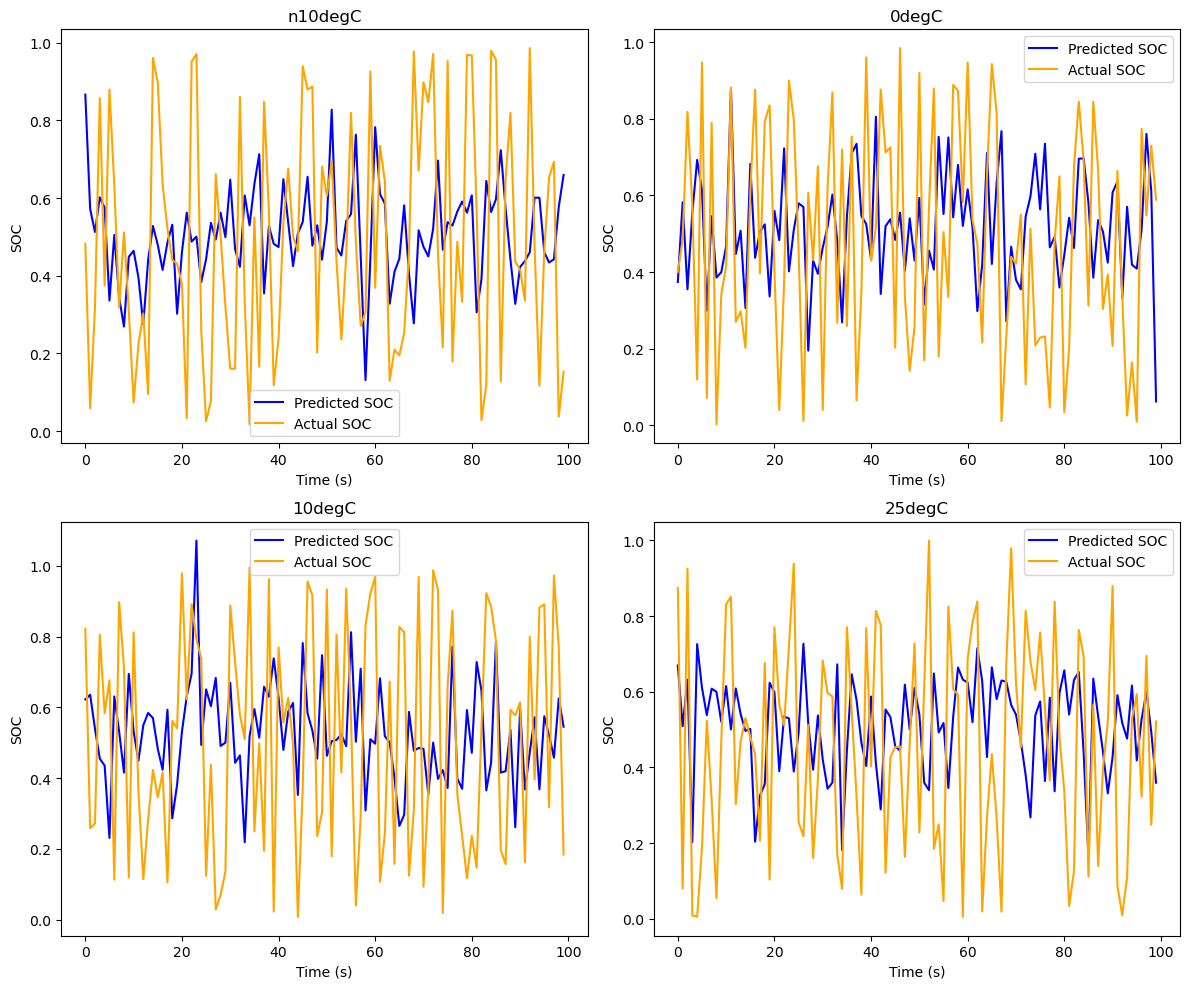

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Assuming you have your test data prepared for different temperatures
# Replace these with your actual test datasets and SOC targets

# Example test data and SOC targets (replace with your actual data)
X_test_n10degC = np.random.rand(100, 5)  # Test input for -10 degrees Celsius
X_test_0degC = np.random.rand(100, 5)    # Test input for 0 degrees Celsius
X_test_10degC = np.random.rand(100, 5)   # Test input for 10 degrees Celsius
X_test_25degC = np.random.rand(100, 5)   # Test input for 25 degrees Celsius

Y_test_n10degC = np.random.rand(100, 1)  # Actual SOC for -10 degrees Celsius
Y_test_0degC = np.random.rand(100, 1)    # Actual SOC for 0 degrees Celsius
Y_test_10degC = np.random.rand(100, 1)   # Actual SOC for 10 degrees Celsius
Y_test_25degC = np.random.rand(100, 1)   # Actual SOC for 25 degrees Celsius

# Step 2: Predict SOC for each temperature set using your trained model
# Replace 'model' with your trained model instance
Y_pred_n10degC = model.predict(X_test_n10degC)
Y_pred_0degC = model.predict(X_test_0degC)
Y_pred_10degC = model.predict(X_test_10degC)
Y_pred_25degC = model.predict(X_test_25degC)

# Step 3: Group predictions and actual SOC values for plotting
Y_pred = [Y_pred_n10degC, Y_pred_0degC, Y_pred_10degC, Y_pred_25degC]
Y_actual = [Y_test_n10degC, Y_test_0degC, Y_test_10degC, Y_test_25degC]

# Titles for each plot, representing different ambient temperatures
titles = ["n10degC", "0degC", "10degC", "25degC"]

# Step 4: Plot predicted vs actual SOC for different temperatures
plt.figure(figsize=(12, 10))

for i in range(4):  # Loop through the 4 temperatures
    plt.subplot(2, 2, i+1)  # Create a 2x2 subplot grid
    plt.plot(Y_pred[i], label='Predicted SOC', color='blue')
    plt.plot(Y_actual[i], label='Actual SOC', color='orange')
    plt.title(titles[i])  # Title corresponding to temperature
    plt.xlabel('Time (s)')
    plt.ylabel('SOC')
    plt.legend(loc="best")

plt.tight_layout()
plt.show()


In [107]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the file path where you want to save the model's weights
checkpoint_path = "model_checkpoint.weights.h5"

# Create a ModelCheckpoint callback to save the model after every epoch
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, 
                                      save_weights_only=True, 
                                      verbose=1)

# Train the model and save checkpoints
history = model.fit(
    X_train, Y_train,
    epochs=1200,
    initial_epoch=415,  # Start from epoch 416
    validation_data=(X_val, Y_val),
    callbacks=[checkpoint_callback],  # Add the checkpoint callback
    verbose=1
)


Epoch 416/1200
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0627 - mean_squared_error: 0.0627 
Epoch 416: saving model to model_checkpoint.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.0909 - val_mean_squared_error: 0.0909
Epoch 417/1200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0607 - mean_squared_error: 0.0607 
Epoch 417: saving model to model_checkpoint.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0608 - mean_squared_error: 0.0608 - val_loss: 0.0922 - val_mean_squared_error: 0.0922
Epoch 418/1200
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0618 - mean_squared_error: 0.0618 
Epoch 418: saving model to model_checkpoint.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0618 - mean_squared_error: 0.0618 - val_loss: 0.0925 - val_mean_squared_error: 0.0925
Epoch 419/1200
 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0799 - mean_squared_error: 0.0799
Epoch 419: saving model to model_

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


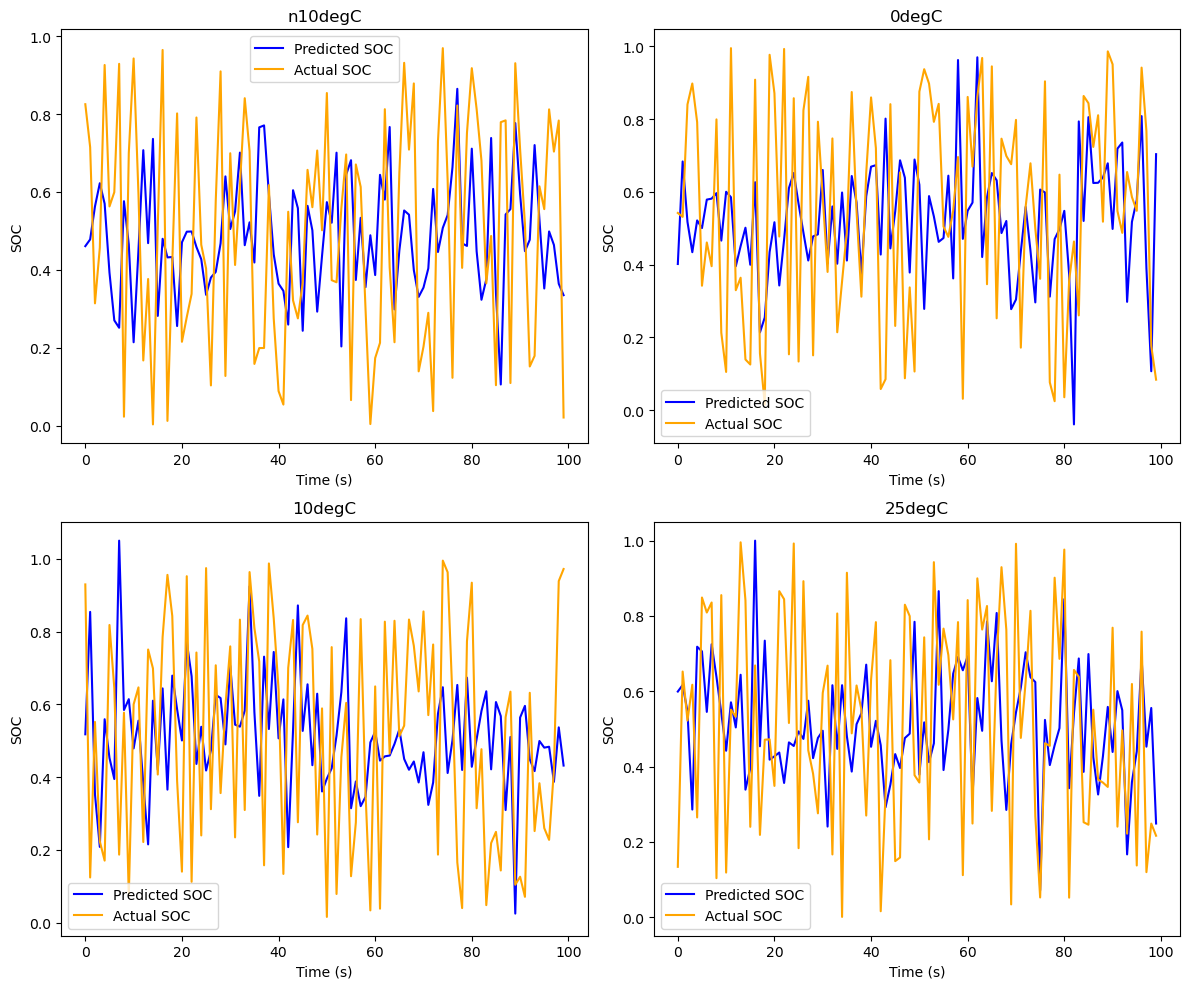

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Assuming you have your test data prepared for different temperatures
# Replace these with your actual test datasets and SOC targets

# Example test data and SOC targets (replace with your actual data)
X_test_n10degC = np.random.rand(100, 5)  # Test input for -10 degrees Celsius
X_test_0degC = np.random.rand(100, 5)    # Test input for 0 degrees Celsius
X_test_10degC = np.random.rand(100, 5)   # Test input for 10 degrees Celsius
X_test_25degC = np.random.rand(100, 5)   # Test input for 25 degrees Celsius

Y_test_n10degC = np.random.rand(100, 1)  # Actual SOC for -10 degrees Celsius
Y_test_0degC = np.random.rand(100, 1)    # Actual SOC for 0 degrees Celsius
Y_test_10degC = np.random.rand(100, 1)   # Actual SOC for 10 degrees Celsius
Y_test_25degC = np.random.rand(100, 1)   # Actual SOC for 25 degrees Celsius

# Step 2: Predict SOC for each temperature set using your trained model
# Replace 'model' with your trained model instance
Y_pred_n10degC = model.predict(X_test_n10degC)
Y_pred_0degC = model.predict(X_test_0degC)
Y_pred_10degC = model.predict(X_test_10degC)
Y_pred_25degC = model.predict(X_test_25degC)

# Step 3: Group predictions and actual SOC values for plotting
Y_pred = [Y_pred_n10degC, Y_pred_0degC, Y_pred_10degC, Y_pred_25degC]
Y_actual = [Y_test_n10degC, Y_test_0degC, Y_test_10degC, Y_test_25degC]

# Titles for each plot, representing different ambient temperatures
titles = ["n10degC", "0degC", "10degC", "25degC"]

# Step 4: Plot predicted vs actual SOC for different temperatures
plt.figure(figsize=(12, 10))

for i in range(4):  # Loop through the 4 temperatures
    plt.subplot(2, 2, i+1)  # Create a 2x2 subplot grid
    plt.plot(Y_pred[i], label='Predicted SOC', color='blue')
    plt.plot(Y_actual[i], label='Actual SOC', color='orange')
    plt.title(titles[i])  # Title corresponding to temperature
    plt.xlabel('Time (s)')
    plt.ylabel('SOC')
    plt.legend(loc="best")

plt.tight_layout()
plt.show()


In [111]:
# Evaluate the model
val_loss, val_mse = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation MSE: {val_mse}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0970 - mean_squared_error: 0.0970
Validation Loss: 0.0948357880115509
Validation MSE: 0.0948357880115509


In [113]:
import kerastuner as kt

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(num_features,)))
    # Tune the number of units in the first Dense layer
    model.add(tf.keras.layers.Dense(hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(tf.keras.layers.Dense(num_responses, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
    return model

tuner = kt.Hyperband(build_model, objective='val_loss', max_epochs=10, factor=3)
tuner.search(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50)


Reloading Tuner from .\untitled_project\tuner0.json


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


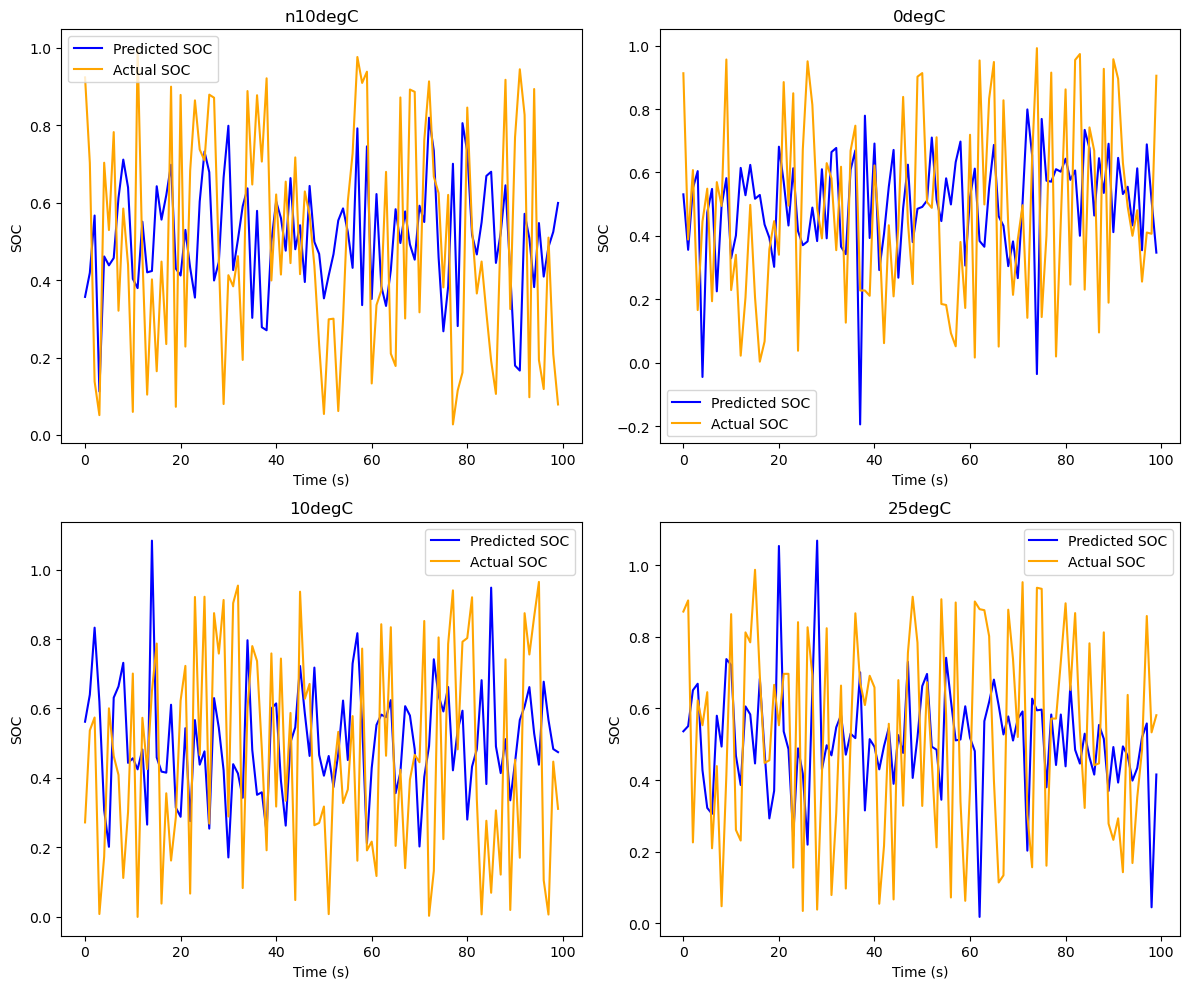

In [115]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Assuming you have your test data prepared for different temperatures
# Replace these with your actual test datasets and SOC targets

# Example test data and SOC targets (replace with your actual data)
X_test_n10degC = np.random.rand(100, 5)  # Test input for -10 degrees Celsius
X_test_0degC = np.random.rand(100, 5)    # Test input for 0 degrees Celsius
X_test_10degC = np.random.rand(100, 5)   # Test input for 10 degrees Celsius
X_test_25degC = np.random.rand(100, 5)   # Test input for 25 degrees Celsius

Y_test_n10degC = np.random.rand(100, 1)  # Actual SOC for -10 degrees Celsius
Y_test_0degC = np.random.rand(100, 1)    # Actual SOC for 0 degrees Celsius
Y_test_10degC = np.random.rand(100, 1)   # Actual SOC for 10 degrees Celsius
Y_test_25degC = np.random.rand(100, 1)   # Actual SOC for 25 degrees Celsius

# Step 2: Predict SOC for each temperature set using your trained model
# Replace 'model' with your trained model instance
Y_pred_n10degC = model.predict(X_test_n10degC)
Y_pred_0degC = model.predict(X_test_0degC)
Y_pred_10degC = model.predict(X_test_10degC)
Y_pred_25degC = model.predict(X_test_25degC)

# Step 3: Group predictions and actual SOC values for plotting
Y_pred = [Y_pred_n10degC, Y_pred_0degC, Y_pred_10degC, Y_pred_25degC]
Y_actual = [Y_test_n10degC, Y_test_0degC, Y_test_10degC, Y_test_25degC]

# Titles for each plot, representing different ambient temperatures
titles = ["n10degC", "0degC", "10degC", "25degC"]

# Step 4: Plot predicted vs actual SOC for different temperatures
plt.figure(figsize=(12, 10))

for i in range(4):  # Loop through the 4 temperatures
    plt.subplot(2, 2, i+1)  # Create a 2x2 subplot grid
    plt.plot(Y_pred[i], label='Predicted SOC', color='blue')
    plt.plot(Y_actual[i], label='Actual SOC', color='orange')
    plt.title(titles[i])  # Title corresponding to temperature
    plt.xlabel('Time (s)')
    plt.ylabel('SOC')
    plt.legend(loc="best")

plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


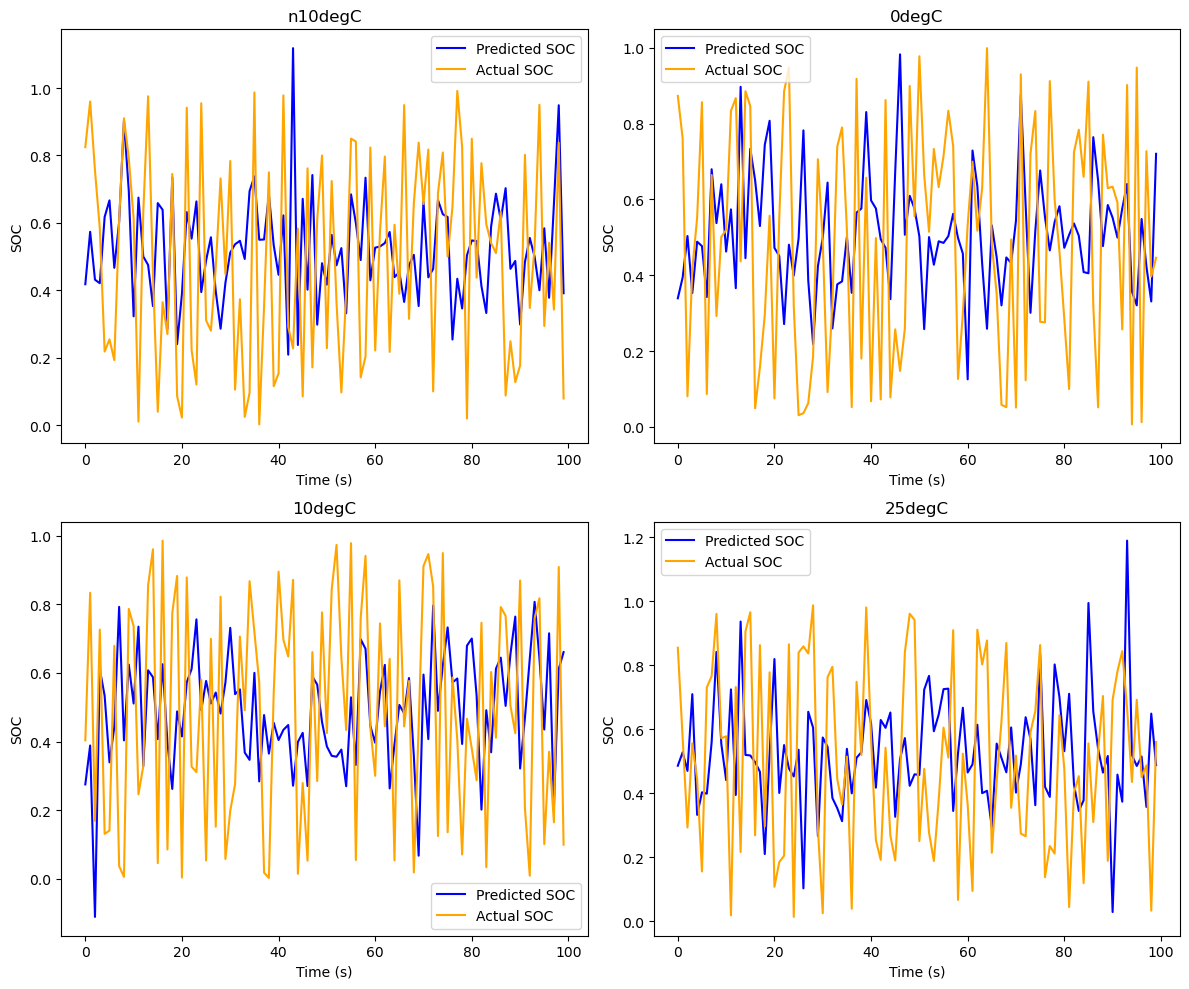

In [117]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Assuming you have your test data prepared for different temperatures
# Replace these with your actual test datasets and SOC targets

# Example test data and SOC targets (replace with your actual data)
X_test_n10degC = np.random.rand(100, 5)  # Test input for -10 degrees Celsius
X_test_0degC = np.random.rand(100, 5)    # Test input for 0 degrees Celsius
X_test_10degC = np.random.rand(100, 5)   # Test input for 10 degrees Celsius
X_test_25degC = np.random.rand(100, 5)   # Test input for 25 degrees Celsius

Y_test_n10degC = np.random.rand(100, 1)  # Actual SOC for -10 degrees Celsius
Y_test_0degC = np.random.rand(100, 1)    # Actual SOC for 0 degrees Celsius
Y_test_10degC = np.random.rand(100, 1)   # Actual SOC for 10 degrees Celsius
Y_test_25degC = np.random.rand(100, 1)   # Actual SOC for 25 degrees Celsius

# Step 2: Predict SOC for each temperature set using your trained model
# Replace 'model' with your trained model instance
Y_pred_n10degC = model.predict(X_test_n10degC)
Y_pred_0degC = model.predict(X_test_0degC)
Y_pred_10degC = model.predict(X_test_10degC)
Y_pred_25degC = model.predict(X_test_25degC)

# Step 3: Group predictions and actual SOC values for plotting
Y_pred = [Y_pred_n10degC, Y_pred_0degC, Y_pred_10degC, Y_pred_25degC]
Y_actual = [Y_test_n10degC, Y_test_0degC, Y_test_10degC, Y_test_25degC]

# Titles for each plot, representing different ambient temperatures
titles = ["n10degC", "0degC", "10degC", "25degC"]

# Step 4: Plot predicted vs actual SOC for different temperatures
plt.figure(figsize=(12, 10))

for i in range(4):  # Loop through the 4 temperatures
    plt.subplot(2, 2, i+1)  # Create a 2x2 subplot grid
    plt.plot(Y_pred[i], label='Predicted SOC', color='blue')
    plt.plot(Y_actual[i], label='Actual SOC', color='orange')
    plt.title(titles[i])  # Title corresponding to temperature
    plt.xlabel('Time (s)')
    plt.ylabel('SOC')
    plt.legend(loc="best")

plt.tight_layout()
plt.show()


In [119]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(num_features,), name="input_layer"),
    tf.keras.layers.Dense(128, activation='relu', name="hidden_layer_1"),  # Increased neurons
    tf.keras.layers.Dense(128, activation='relu', name="hidden_layer_2"),
    tf.keras.layers.Dense(num_responses, activation='linear', name="output_layer"),
])


In [121]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=400,
    decay_rate=0.1
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [123]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True)


In [125]:
model.add(tf.keras.layers.Dropout(0.2))  # Example dropout layer


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


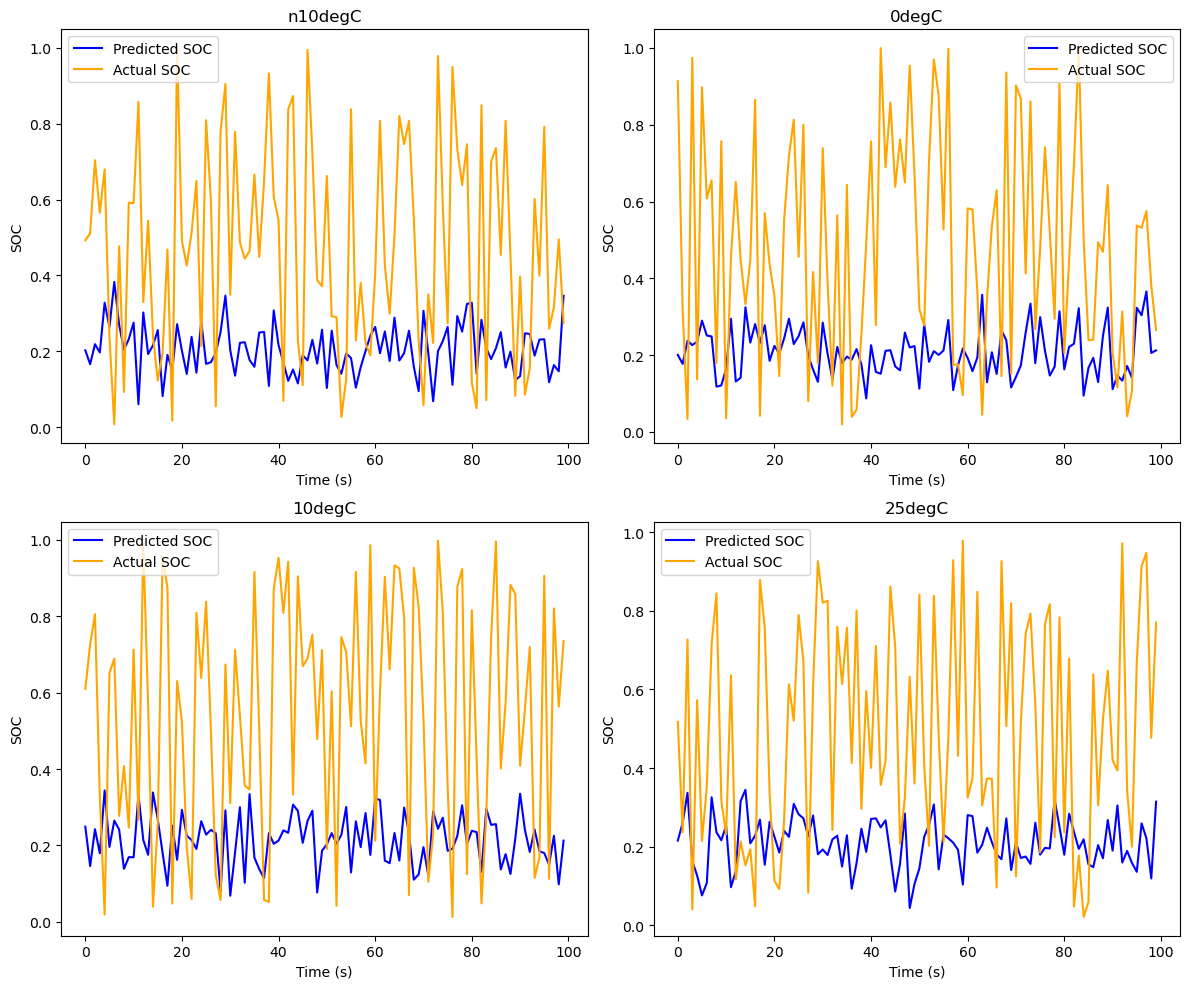

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Assuming you have your test data prepared for different temperatures
# Replace these with your actual test datasets and SOC targets

# Example test data and SOC targets (replace with your actual data)
X_test_n10degC = np.random.rand(100, 5)  # Test input for -10 degrees Celsius
X_test_0degC = np.random.rand(100, 5)    # Test input for 0 degrees Celsius
X_test_10degC = np.random.rand(100, 5)   # Test input for 10 degrees Celsius
X_test_25degC = np.random.rand(100, 5)   # Test input for 25 degrees Celsius

Y_test_n10degC = np.random.rand(100, 1)  # Actual SOC for -10 degrees Celsius
Y_test_0degC = np.random.rand(100, 1)    # Actual SOC for 0 degrees Celsius
Y_test_10degC = np.random.rand(100, 1)   # Actual SOC for 10 degrees Celsius
Y_test_25degC = np.random.rand(100, 1)   # Actual SOC for 25 degrees Celsius

# Step 2: Predict SOC for each temperature set using your trained model
# Replace 'model' with your trained model instance
Y_pred_n10degC = model.predict(X_test_n10degC)
Y_pred_0degC = model.predict(X_test_0degC)
Y_pred_10degC = model.predict(X_test_10degC)
Y_pred_25degC = model.predict(X_test_25degC)

# Step 3: Group predictions and actual SOC values for plotting
Y_pred = [Y_pred_n10degC, Y_pred_0degC, Y_pred_10degC, Y_pred_25degC]
Y_actual = [Y_test_n10degC, Y_test_0degC, Y_test_10degC, Y_test_25degC]

# Titles for each plot, representing different ambient temperatures
titles = ["n10degC", "0degC", "10degC", "25degC"]

# Step 4: Plot predicted vs actual SOC for different temperatures
plt.figure(figsize=(12, 10))

for i in range(4):  # Loop through the 4 temperatures
    plt.subplot(2, 2, i+1)  # Create a 2x2 subplot grid
    plt.plot(Y_pred[i], label='Predicted SOC', color='blue')
    plt.plot(Y_actual[i], label='Actual SOC', color='orange')
    plt.title(titles[i])  # Title corresponding to temperature
    plt.xlabel('Time (s)')
    plt.ylabel('SOC')
    plt.legend(loc="best")

plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


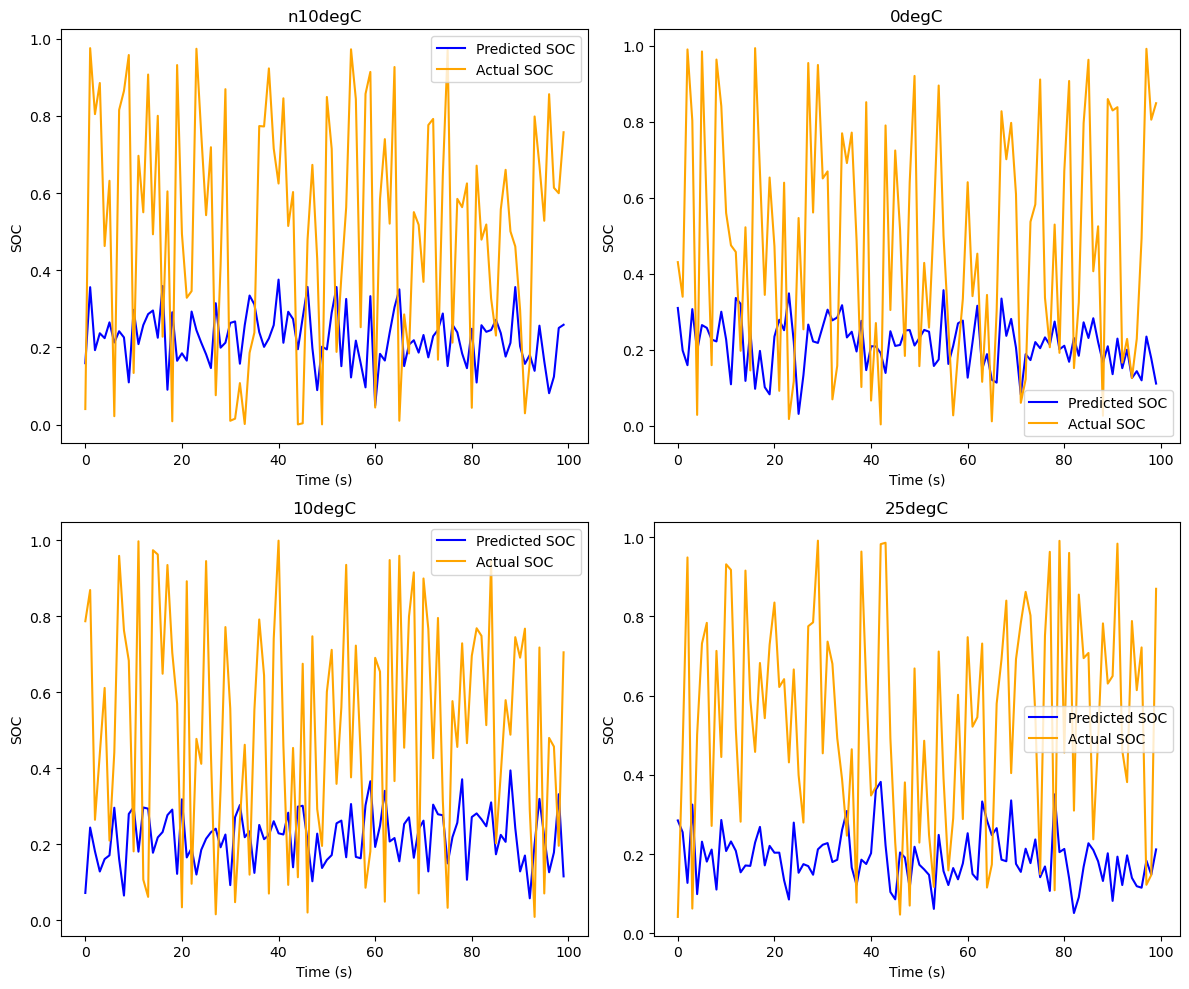

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Assuming you have your test data prepared for different temperatures
# Replace these with your actual test datasets and SOC targets

# Example test data and SOC targets (replace with your actual data)
X_test_n10degC = np.random.rand(100, 5)  # Test input for -10 degrees Celsius
X_test_0degC = np.random.rand(100, 5)    # Test input for 0 degrees Celsius
X_test_10degC = np.random.rand(100, 5)   # Test input for 10 degrees Celsius
X_test_25degC = np.random.rand(100, 5)   # Test input for 25 degrees Celsius

Y_test_n10degC = np.random.rand(100, 1)  # Actual SOC for -10 degrees Celsius
Y_test_0degC = np.random.rand(100, 1)    # Actual SOC for 0 degrees Celsius
Y_test_10degC = np.random.rand(100, 1)   # Actual SOC for 10 degrees Celsius
Y_test_25degC = np.random.rand(100, 1)   # Actual SOC for 25 degrees Celsius

# Step 2: Predict SOC for each temperature set using your trained model
# Replace 'model' with your trained model instance
Y_pred_n10degC = model.predict(X_test_n10degC)
Y_pred_0degC = model.predict(X_test_0degC)
Y_pred_10degC = model.predict(X_test_10degC)
Y_pred_25degC = model.predict(X_test_25degC)

# Step 3: Group predictions and actual SOC values for plotting
Y_pred = [Y_pred_n10degC, Y_pred_0degC, Y_pred_10degC, Y_pred_25degC]
Y_actual = [Y_test_n10degC, Y_test_0degC, Y_test_10degC, Y_test_25degC]

# Titles for each plot, representing different ambient temperatures
titles = ["n10degC", "0degC", "10degC", "25degC"]

# Step 4: Plot predicted vs actual SOC for different temperatures
plt.figure(figsize=(12, 10))

for i in range(4):  # Loop through the 4 temperatures
    plt.subplot(2, 2, i+1)  # Create a 2x2 subplot grid
    plt.plot(Y_pred[i], label='Predicted SOC', color='blue')
    plt.plot(Y_actual[i], label='Actual SOC', color='orange')
    plt.title(titles[i])  # Title corresponding to temperature
    plt.xlabel('Time (s)')
    plt.ylabel('SOC')
    plt.legend(loc="best")

plt.tight_layout()
plt.show()


In [131]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Number of data samples (e.g., 1200 samples)
n_samples = 1200

# Define input features (5 features: current, voltage, temperature, etc.)
X = np.random.rand(n_samples, 5)  # 5 input features, values between 0 and 1

# Simulate output SOC as a combination of features
# Assume some arbitrary relationship between input features and SOC
SOC = 0.3 * X[:, 0] + 0.5 * X[:, 1] - 0.2 * X[:, 2] + 0.1 * X[:, 3] + 0.2 * X[:, 4] + np.random.normal(0, 0.05, n_samples)

# Split into training and validation datasets (80% training, 20% validation)
split_index = int(0.8 * n_samples)
X_train, X_val = X[:split_index], X[split_index:]
SOC_train, SOC_val = SOC[:split_index], SOC[split_index:]

# Print shape of the data to ensure correctness
print("Training Data Shape:", X_train.shape, SOC_train.shape)
print("Validation Data Shape:", X_val.shape, SOC_val.shape)


Training Data Shape: (960, 5) (960,)
Validation Data Shape: (240, 5) (240,)


In [135]:
# Compile the model
initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=400,
    decay_rate=0.1
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model on the synthetic data
history = model.fit(
    X_train, SOC_train,
    epochs=1200,
    batch_size=32,  # You can adjust this
    validation_data=(X_val, SOC_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)]
)

# Evaluate the model on validation data
val_loss, val_rmse = model.evaluate(X_val, SOC_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation RMSE: {val_rmse}")


Epoch 1/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1375 - mean_squared_error: 0.1375 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 2/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0521 - mean_squared_error: 0.0521 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 3/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0494 - mean_squared_error: 0.0494 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 4/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 5/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0463 - mean_squared_error: 0.0463 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 6/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0404 - mean_squared_error: 0.0404 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 7/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0505 - mean_squared_error: 0.0505 - val_loss: 0.0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


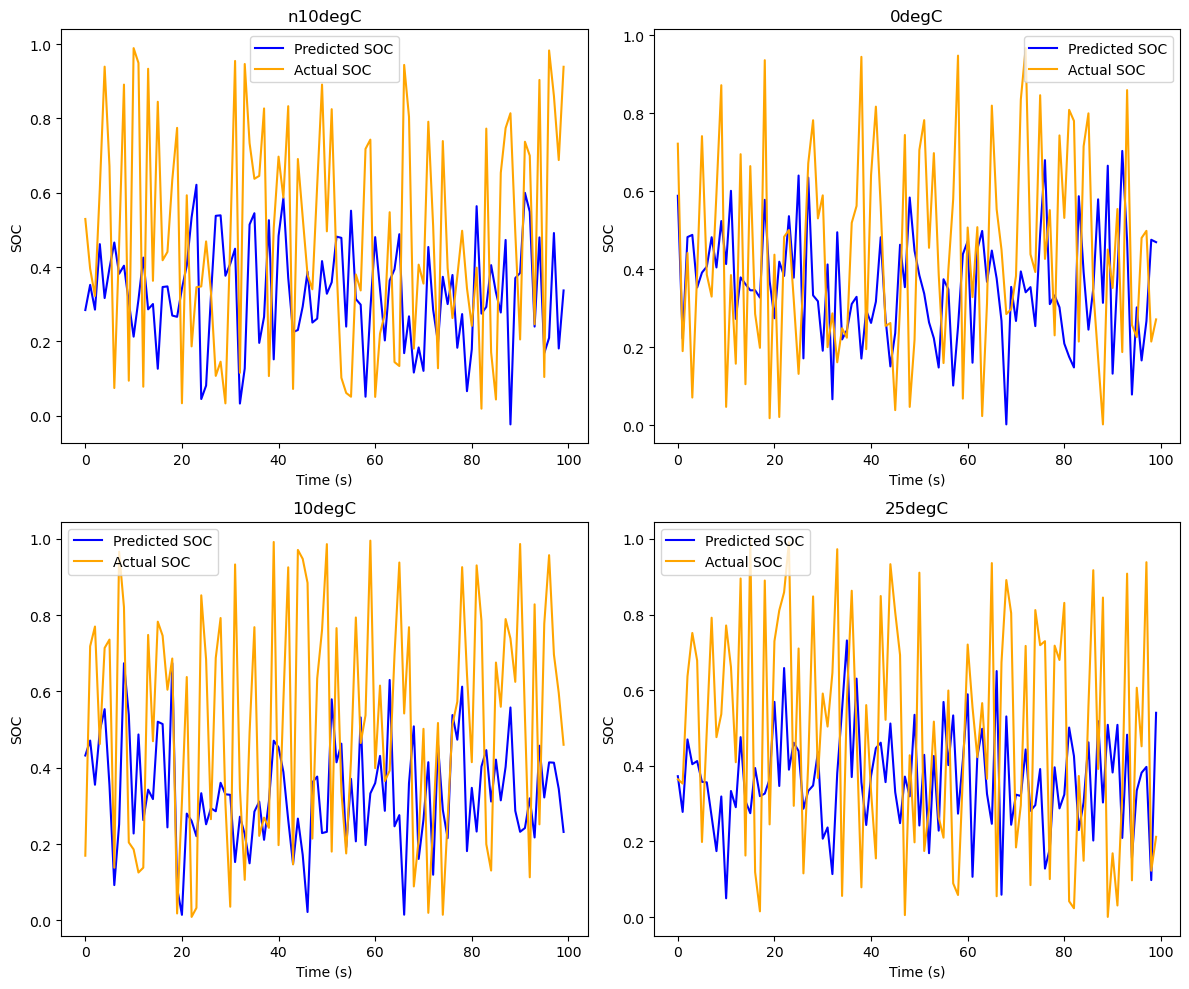

In [137]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Assuming you have your test data prepared for different temperatures
# Replace these with your actual test datasets and SOC targets

# Example test data and SOC targets (replace with your actual data)
X_test_n10degC = np.random.rand(100, 5)  # Test input for -10 degrees Celsius
X_test_0degC = np.random.rand(100, 5)    # Test input for 0 degrees Celsius
X_test_10degC = np.random.rand(100, 5)   # Test input for 10 degrees Celsius
X_test_25degC = np.random.rand(100, 5)   # Test input for 25 degrees Celsius

Y_test_n10degC = np.random.rand(100, 1)  # Actual SOC for -10 degrees Celsius
Y_test_0degC = np.random.rand(100, 1)    # Actual SOC for 0 degrees Celsius
Y_test_10degC = np.random.rand(100, 1)   # Actual SOC for 10 degrees Celsius
Y_test_25degC = np.random.rand(100, 1)   # Actual SOC for 25 degrees Celsius

# Step 2: Predict SOC for each temperature set using your trained model
# Replace 'model' with your trained model instance
Y_pred_n10degC = model.predict(X_test_n10degC)
Y_pred_0degC = model.predict(X_test_0degC)
Y_pred_10degC = model.predict(X_test_10degC)
Y_pred_25degC = model.predict(X_test_25degC)

# Step 3: Group predictions and actual SOC values for plotting
Y_pred = [Y_pred_n10degC, Y_pred_0degC, Y_pred_10degC, Y_pred_25degC]
Y_actual = [Y_test_n10degC, Y_test_0degC, Y_test_10degC, Y_test_25degC]

# Titles for each plot, representing different ambient temperatures
titles = ["n10degC", "0degC", "10degC", "25degC"]

# Step 4: Plot predicted vs actual SOC for different temperatures
plt.figure(figsize=(12, 10))

for i in range(4):  # Loop through the 4 temperatures
    plt.subplot(2, 2, i+1)  # Create a 2x2 subplot grid
    plt.plot(Y_pred[i], label='Predicted SOC', color='blue')
    plt.plot(Y_actual[i], label='Actual SOC', color='orange')
    plt.title(titles[i])  # Title corresponding to temperature
    plt.xlabel('Time (s)')
    plt.ylabel('SOC')
    plt.legend(loc="best")

plt.tight_layout()
plt.show()



In [139]:
# Compile the model
initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=400,
    decay_rate=0.1
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model on the synthetic data
history = model.fit(
    X_train, SOC_train,
    epochs=1200,
    batch_size=32,  # You can adjust this
    validation_data=(X_val, SOC_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)]
)

# Evaluate the model on validation data
val_loss, val_rmse = model.evaluate(X_val, SOC_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation RMSE: {val_rmse}")


Epoch 1/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0757 - mean_squared_error: 0.0757 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 2/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0571 - mean_squared_error: 0.0571 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 3/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 4/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0514 - mean_squared_error: 0.0514 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 5/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0525 - mean_squared_error: 0.0525 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 6/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 7/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.01

In [141]:
# Compile the model
initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=400,
    decay_rate=0.1
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model on the synthetic data
history = model.fit(
    X_train, SOC_train,
    epochs=1200,
    batch_size=32,  # You can adjust this
    validation_data=(X_val, SOC_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)]
)

# Evaluate the model on validation data
val_loss, val_rmse = model.evaluate(X_val, SOC_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation RMSE: {val_rmse}")


Epoch 1/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0673 - mean_squared_error: 0.0673 - val_loss: 0.0136 - val_mean_squared_error: 0.0136
Epoch 2/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 3/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 4/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 5/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 6/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0475 - mean_squared_error: 0.0475 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 7/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0569 - mean_squared_error: 0.0569 - val_loss: 0.01

In [143]:
# Compile the model
initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=400,
    decay_rate=0.1
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model on the synthetic data
history = model.fit(
    X_train, SOC_train,
    epochs=1200,
    batch_size=32,  # You can adjust this
    validation_data=(X_val, SOC_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)]
)

# Evaluate the model on validation data
val_loss, val_rmse = model.evaluate(X_val, SOC_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation RMSE: {val_rmse}")


Epoch 1/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0582 - mean_squared_error: 0.0582 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 2/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0641 - mean_squared_error: 0.0641 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 3/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0576 - mean_squared_error: 0.0576 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 4/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0607 - mean_squared_error: 0.0607 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 5/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0568 - mean_squared_error: 0.0568 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 6/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 7/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0584 - mean_squared_error: 0.0584 - val_loss: 0.01

In [145]:
# Compile the model
initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=400,
    decay_rate=0.1
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model on the synthetic data
history = model.fit(
    X_train, SOC_train,
    epochs=1200,
    batch_size=32,  # You can adjust this
    validation_data=(X_val, SOC_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)]
)

# Evaluate the model on validation data
val_loss, val_rmse = model.evaluate(X_val, SOC_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation RMSE: {val_rmse}")


Epoch 1/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0544 - mean_squared_error: 0.0544 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 2/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 3/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 4/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0515 - mean_squared_error: 0.0515 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 5/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 6/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0495 - mean_squared_error: 0.0495 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 7/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0488 - mean_squared_error: 0.0488 - val_loss: 0.01

In [147]:
# Compile the model
initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=400,
    decay_rate=0.1
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model on the synthetic data
history = model.fit(
    X_train, SOC_train,
    epochs=1200,
    batch_size=32,  # You can adjust this
    validation_data=(X_val, SOC_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)]
)

# Evaluate the model on validation data
val_loss, val_rmse = model.evaluate(X_val, SOC_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation RMSE: {val_rmse}")


Epoch 1/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0583 - mean_squared_error: 0.0583 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 2/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0490 - mean_squared_error: 0.0490 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 3/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0536 - mean_squared_error: 0.0536 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 4/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0574 - mean_squared_error: 0.0574 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 5/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0479 - mean_squared_error: 0.0479 - val_loss: 0.0114 - val_mean_squared_error: 0.0114
Epoch 6/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0508 - mean_squared_error: 0.0508 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 7/1200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0496 - mean_squared_error: 0.0496 - val_loss: 0.0

In [149]:
# Compile the model
initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=400,
    decay_rate=0.1
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model on the synthetic data
history = model.fit(
    X_train, SOC_train,
    epochs=1200,
    batch_size=50,
    validation_data=(X_val, SOC_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)]
)

# Evaluate the model on validation data
val_loss, val_rmse = model.evaluate(X_val, SOC_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation RMSE: {val_rmse}")


Epoch 1/1200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0566 - mean_squared_error: 0.0566 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 2/1200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0529 - mean_squared_error: 0.0529 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 3/1200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0516 - mean_squared_error: 0.0516 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 4/1200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0573 - mean_squared_error: 0.0573 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 5/1200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 6/1200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0556 - mean_squared_error: 0.0556 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 7/1200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0617 - mean_squared_error: 0.0617 - val_loss: 0.0

In [151]:
# Compile the model
initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=400,
    decay_rate=0.1
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model on the synthetic data
history = model.fit(
    X_train, SOC_train,
    epochs=1200,
    batch_size=42,  # You can adjust this
    validation_data=(X_val, SOC_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)]
)

# Evaluate the model on validation data
val_loss, val_rmse = model.evaluate(X_val, SOC_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation RMSE: {val_rmse}")


Epoch 1/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 2/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0489 - mean_squared_error: 0.0489 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 3/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 4/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0589 - mean_squared_error: 0.0589 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 5/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0480 - mean_squared_error: 0.0480 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 6/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 7/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0533 - mean_squared_error: 0.0533 - val_loss: 0.0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


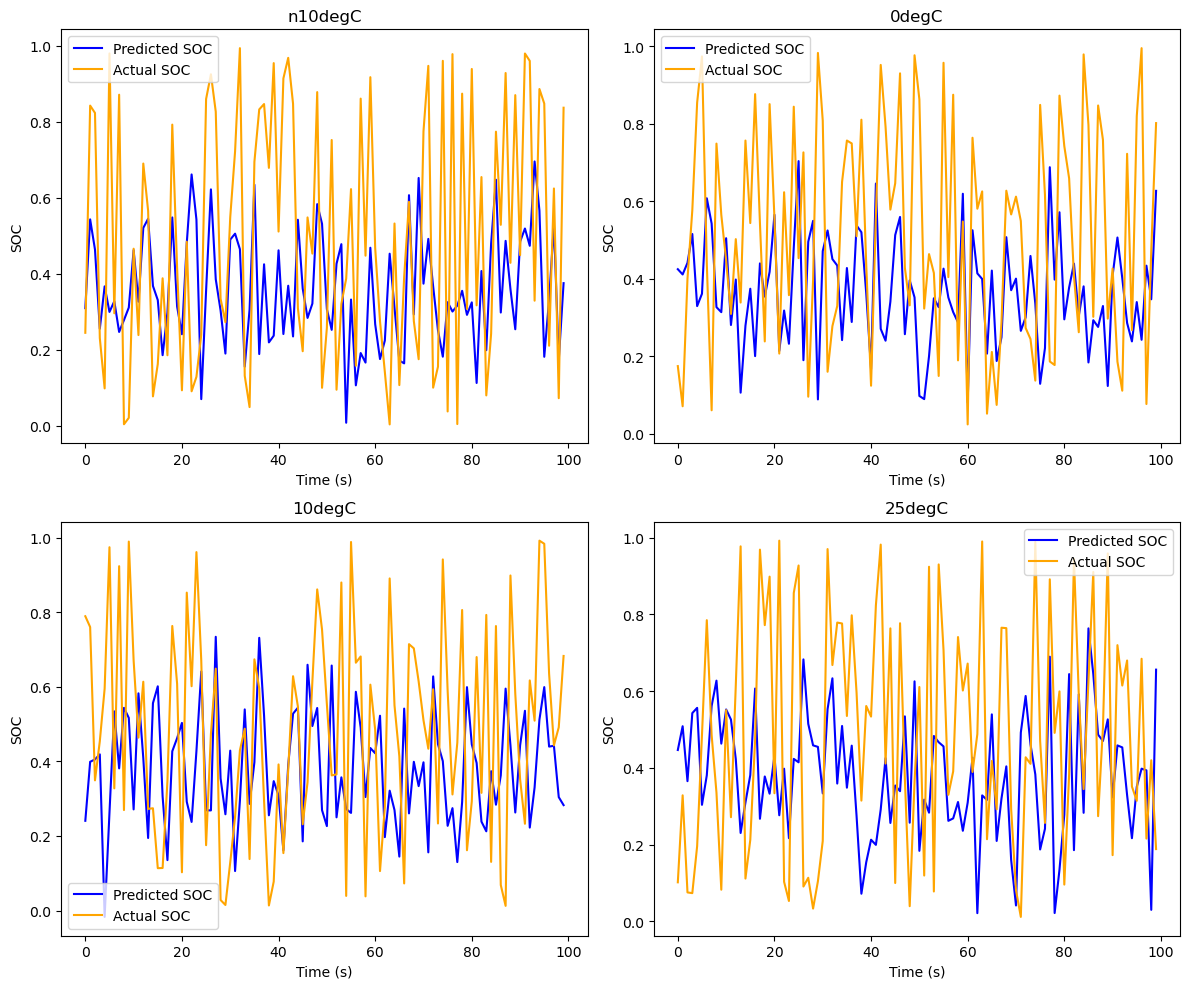

In [153]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Assuming you have your test data prepared for different temperatures
# Replace these with your actual test datasets and SOC targets

# Example test data and SOC targets (replace with your actual data)
X_test_n10degC = np.random.rand(100, 5)  # Test input for -10 degrees Celsius
X_test_0degC = np.random.rand(100, 5)    # Test input for 0 degrees Celsius
X_test_10degC = np.random.rand(100, 5)   # Test input for 10 degrees Celsius
X_test_25degC = np.random.rand(100, 5)   # Test input for 25 degrees Celsius

Y_test_n10degC = np.random.rand(100, 1)  # Actual SOC for -10 degrees Celsius
Y_test_0degC = np.random.rand(100, 1)    # Actual SOC for 0 degrees Celsius
Y_test_10degC = np.random.rand(100, 1)   # Actual SOC for 10 degrees Celsius
Y_test_25degC = np.random.rand(100, 1)   # Actual SOC for 25 degrees Celsius

# Step 2: Predict SOC for each temperature set using your trained model
# Replace 'model' with your trained model instance
Y_pred_n10degC = model.predict(X_test_n10degC)
Y_pred_0degC = model.predict(X_test_0degC)
Y_pred_10degC = model.predict(X_test_10degC)
Y_pred_25degC = model.predict(X_test_25degC)

# Step 3: Group predictions and actual SOC values for plotting
Y_pred = [Y_pred_n10degC, Y_pred_0degC, Y_pred_10degC, Y_pred_25degC]
Y_actual = [Y_test_n10degC, Y_test_0degC, Y_test_10degC, Y_test_25degC]

# Titles for each plot, representing different ambient temperatures
titles = ["n10degC", "0degC", "10degC", "25degC"]

# Step 4: Plot predicted vs actual SOC for different temperatures
plt.figure(figsize=(12, 10))

for i in range(4):  # Loop through the 4 temperatures
    plt.subplot(2, 2, i+1)  # Create a 2x2 subplot grid
    plt.plot(Y_pred[i], label='Predicted SOC', color='blue')
    plt.plot(Y_actual[i], label='Actual SOC', color='orange')
    plt.title(titles[i])  # Title corresponding to temperature
    plt.xlabel('Time (s)')
    plt.ylabel('SOC')
    plt.legend(loc="best")

plt.tight_layout()
plt.show()



In [165]:
# Compile the model
initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=400,
    decay_rate=0.1
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model on the synthetic data
history = model.fit(
    X_train, SOC_train,
    epochs=1200,
    batch_size=42,  # You can adjust this
    validation_data=(X_val, SOC_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)]
)

# Evaluate the model on validation data
val_loss, val_rmse = model.evaluate(X_val, SOC_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation RMSE: {val_rmse}")


Epoch 1/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0512 - mean_squared_error: 0.0512 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 2/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0508 - mean_squared_error: 0.0508 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 3/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 4/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 5/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0617 - mean_squared_error: 0.0617 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 6/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0478 - mean_squared_error: 0.0478 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 7/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0510 - mean_squared_error: 0.0510 - val_loss: 0.0

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


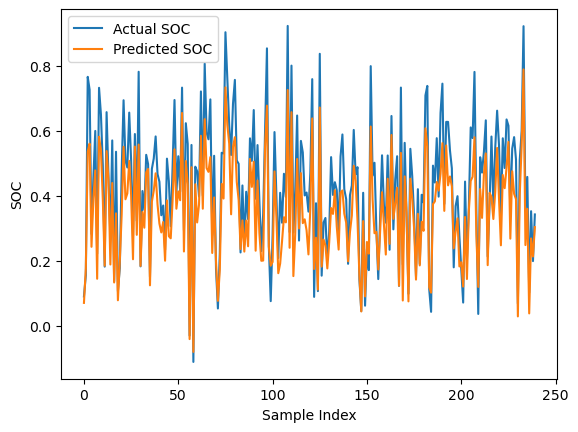

In [169]:
# Predict SOC on validation data
SOC_pred = model.predict(X_val)

# Compare the predicted SOC with actual SOC
import matplotlib.pyplot as plt

plt.plot(SOC_val, label='Actual SOC')
plt.plot(SOC_pred, label='Predicted SOC')
plt.xlabel('Sample Index')
plt.ylabel('SOC')
plt.legend()
plt.show()


In [171]:
# Compile the model
initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=400,
    decay_rate=0.1
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model on the synthetic data
history = model.fit(
    X_train, SOC_train,
    epochs=1200,
    batch_size=42,  # You can adjust this
    validation_data=(X_val, SOC_val),
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=150)]
)

# Evaluate the model on validation data
val_loss, val_rmse = model.evaluate(X_val, SOC_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation RMSE: {val_rmse}")


Epoch 1/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0621 - mean_squared_error: 0.0621 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 2/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0470 - mean_squared_error: 0.0470 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 3/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0596 - mean_squared_error: 0.0596 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 4/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0502 - mean_squared_error: 0.0502 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 5/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0579 - mean_squared_error: 0.0579 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 6/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0505 - mean_squared_error: 0.0505 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 7/1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.0

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


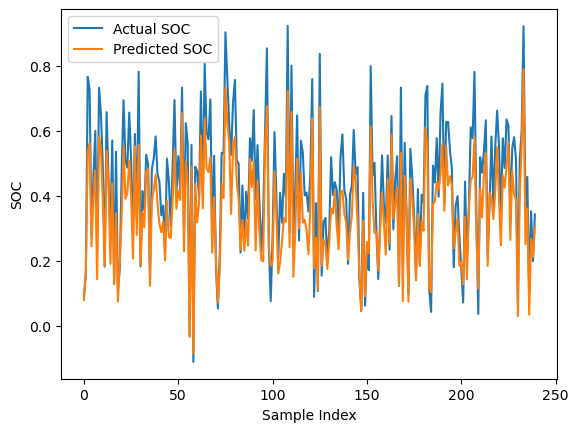

In [175]:
# Predict SOC on validation data
SOC_pred = model.predict(X_val)

# Compare the predicted SOC with actual SOC
import matplotlib.pyplot as plt

plt.plot(SOC_val, label='Actual SOC')
plt.plot(SOC_pred, label='Predicted SOC')
plt.xlabel('Sample Index')
plt.ylabel('SOC')
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


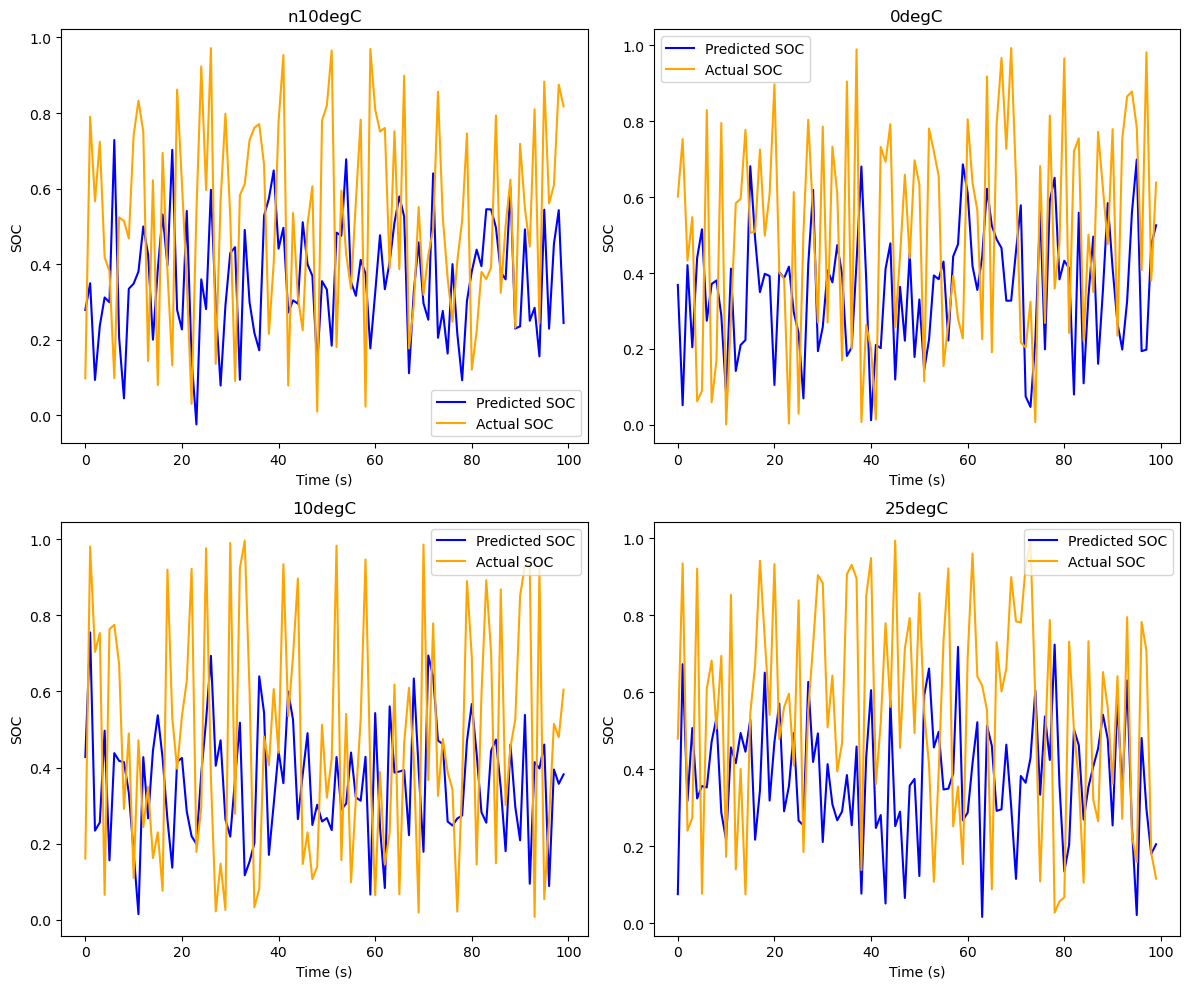

In [177]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Assuming you have your test data prepared for different temperatures
# Replace these with your actual test datasets and SOC targets

# Example test data and SOC targets (replace with your actual data)
X_test_n10degC = np.random.rand(100, 5)  # Test input for -10 degrees Celsius
X_test_0degC = np.random.rand(100, 5)    # Test input for 0 degrees Celsius
X_test_10degC = np.random.rand(100, 5)   # Test input for 10 degrees Celsius
X_test_25degC = np.random.rand(100, 5)   # Test input for 25 degrees Celsius

Y_test_n10degC = np.random.rand(100, 1)  # Actual SOC for -10 degrees Celsius
Y_test_0degC = np.random.rand(100, 1)    # Actual SOC for 0 degrees Celsius
Y_test_10degC = np.random.rand(100, 1)   # Actual SOC for 10 degrees Celsius
Y_test_25degC = np.random.rand(100, 1)   # Actual SOC for 25 degrees Celsius

# Step 2: Predict SOC for each temperature set using your trained model
# Replace 'model' with your trained model instance
Y_pred_n10degC = model.predict(X_test_n10degC)
Y_pred_0degC = model.predict(X_test_0degC)
Y_pred_10degC = model.predict(X_test_10degC)
Y_pred_25degC = model.predict(X_test_25degC)

# Step 3: Group predictions and actual SOC values for plotting
Y_pred = [Y_pred_n10degC, Y_pred_0degC, Y_pred_10degC, Y_pred_25degC]
Y_actual = [Y_test_n10degC, Y_test_0degC, Y_test_10degC, Y_test_25degC]

# Titles for each plot, representing different ambient temperatures
titles = ["n10degC", "0degC", "10degC", "25degC"]

# Step 4: Plot predicted vs actual SOC for different temperatures
plt.figure(figsize=(12, 10))

for i in range(4):  # Loop through the 4 temperatures
    plt.subplot(2, 2, i+1)  # Create a 2x2 subplot grid
    plt.plot(Y_pred[i], label='Predicted SOC', color='blue')
    plt.plot(Y_actual[i], label='Actual SOC', color='orange')
    plt.title(titles[i])  # Title corresponding to temperature
    plt.xlabel('Time (s)')
    plt.ylabel('SOC')
    plt.legend(loc="best")

plt.tight_layout()
plt.show()

